# AOMA on HDF5 data

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.processer import welch_plot
import os
import koma.oma, koma.plot
import koma.clustering

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = '../Data/Halogaland_second_try.hdf5'

loader= dl.HDF5_dataloader(os.getcwd()+'/../Data/Halogaland_second_try.hdf5')

In [11]:
acc = loader.load_all_acceleration_data(loader.periods[1], preprosess=True, cutoff_frequency=1, filter_order=10)
print(acc.shape)

(57600, 48)


In [12]:
acc_welch =  acc[:,16]
print(acc_welch.shape)

(57600,)


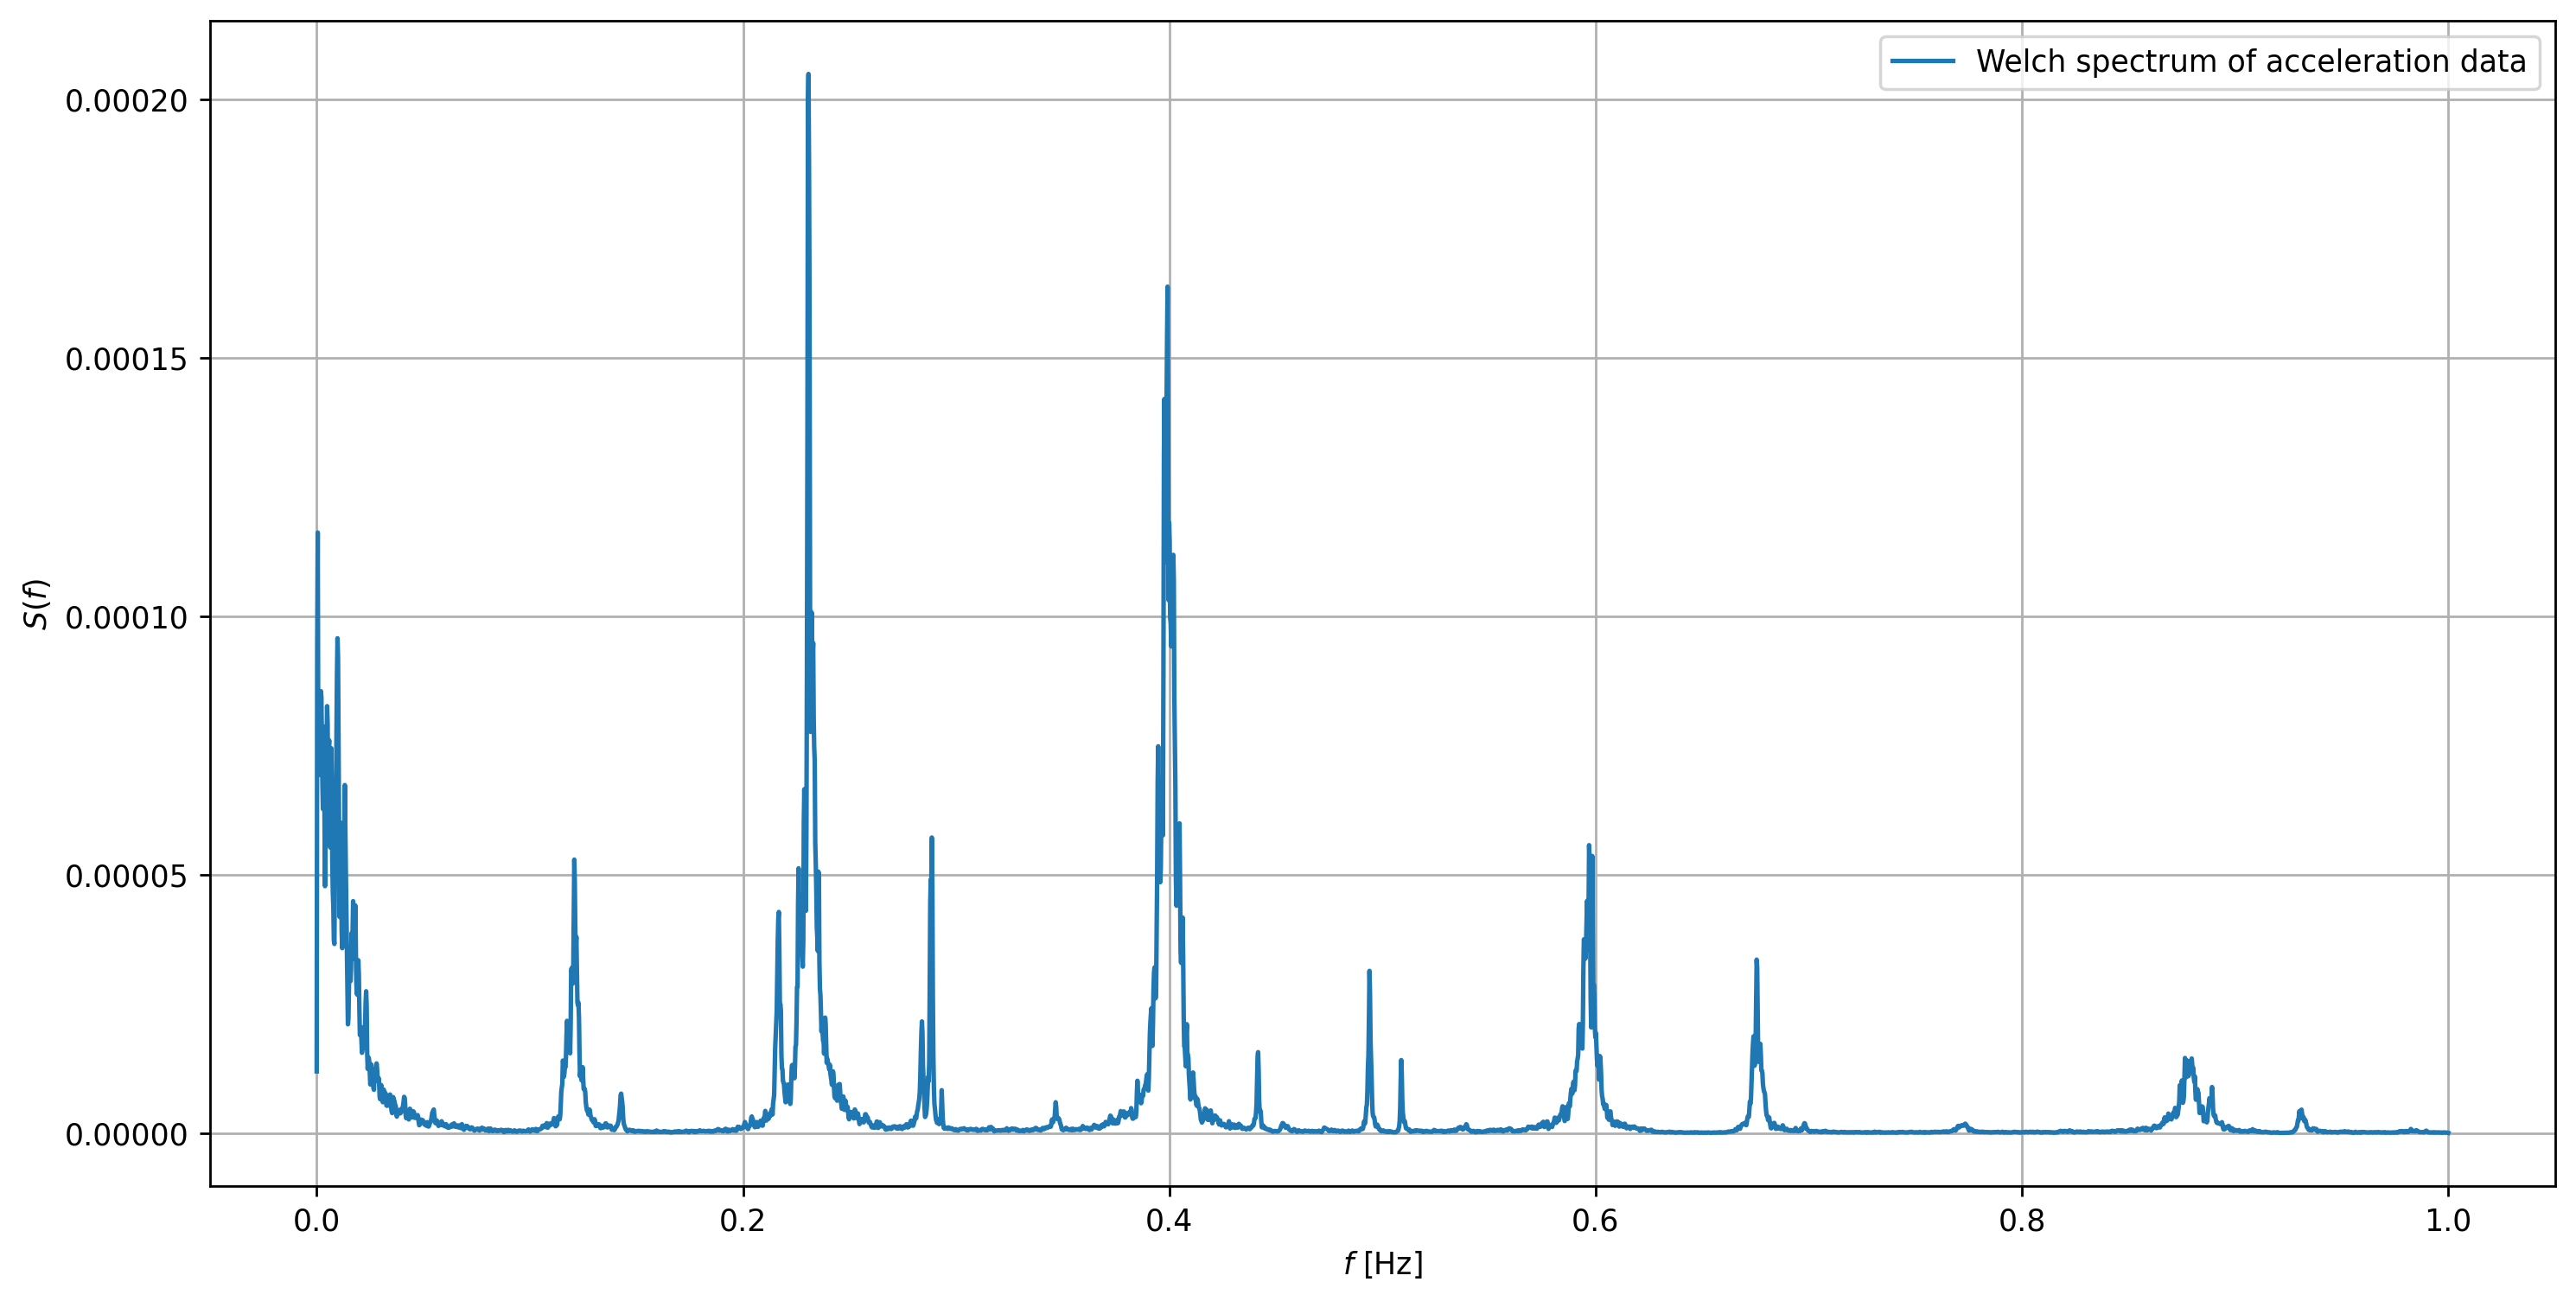

In [13]:
welch_plot(acc_welch, 2, 10)

### Cov-SSI

In [14]:
i = 24
s = 6
fs = 2
orders = np.arange(2, 150+2, 2)

stabcrit = {'freq': 0.05, 'damping': 0.1, 'mac': 0.1} # Default

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


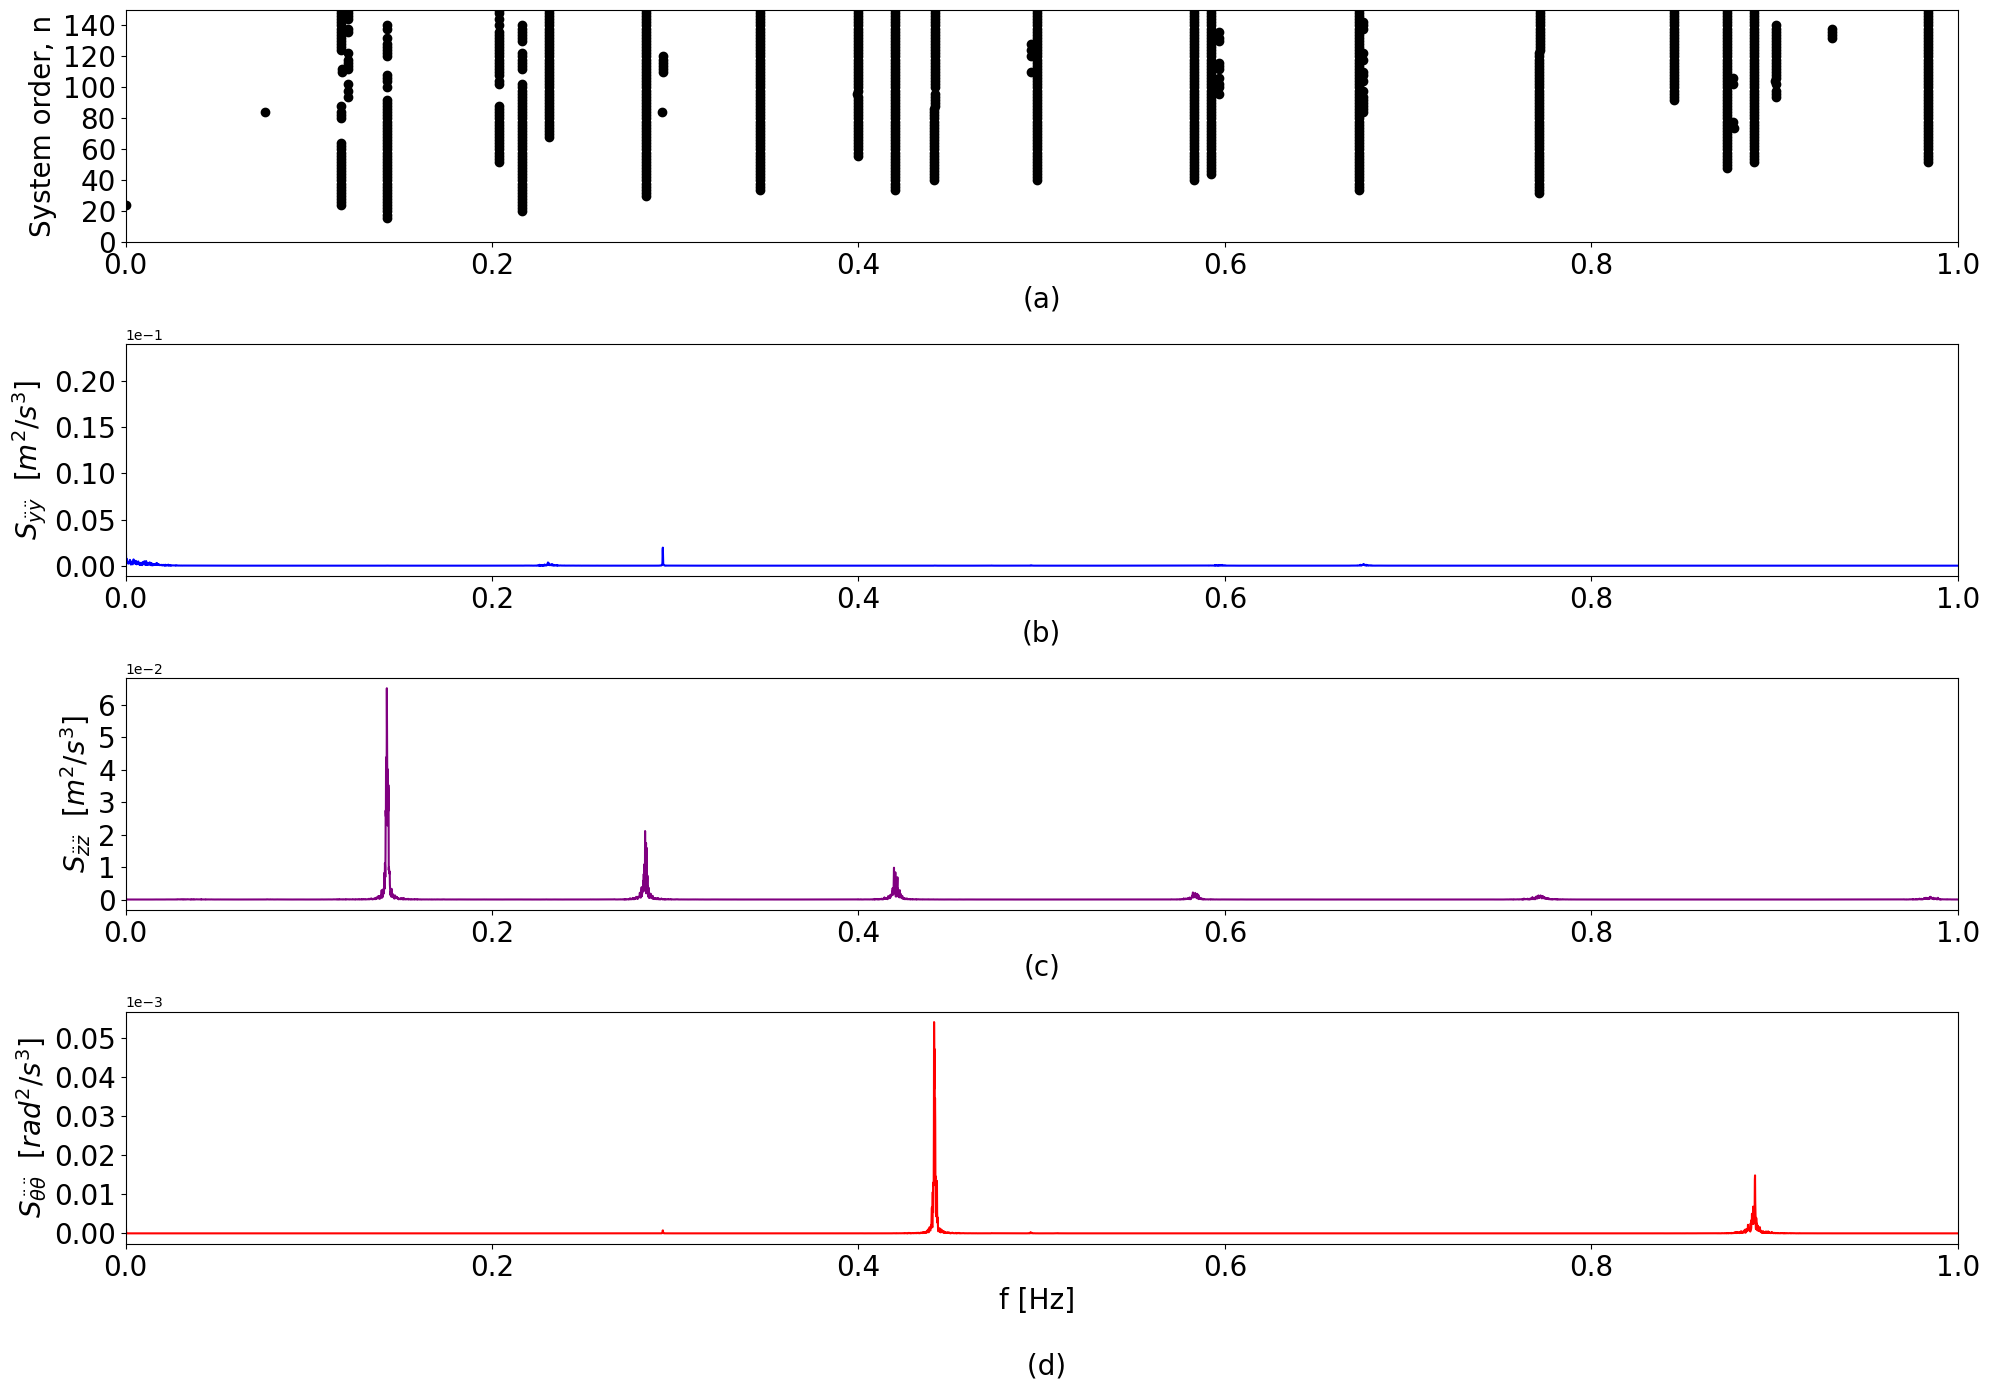

In [15]:
from python_appendix import OMA_functions as OMA
#Cov-SSI call
#lambd, phi = koma.oma.covssi(acc[:18000,:], fs, i, orders, showinfo=True) # find poles by Cov-SSI
#lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

#print(lambd_stab.shape)
#print(phi_stab.shape)

f_n_sort, ksi_sort, phi_sort, fig, lambd_stab, phi_stab, orders_stab = OMA.modalParamOMA(acc, fs, orders, i, s, stabcrit=stabcrit, autoSpectrum=True)

In [16]:
#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
prob_threshold = 0.7   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling


In [17]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

$f_n$ [Hz]  $\xi$ [%]
0     0.117661   1.188119
1     0.117716   1.063892
2     0.121444   1.811641
3     0.142705   0.363305
4     0.142711   0.363657
5     0.203632   0.378416
6     0.203636   0.352187
7     0.216455   0.423200
8     0.216533   0.406335
9     0.231220   1.255196
10    0.231221   1.263759
11    0.283806   0.286103
12    0.283838   0.289106
13    0.346424   0.405905
14    0.346434   0.411339
15    0.399522   0.762783
16    0.399612   0.736349
17    0.420138   0.279691
18    0.420138   0.278727
19    0.441477   0.093211
20    0.441525   0.101257
21    0.441526   0.102375
22    0.497302   0.381759
23    0.497388   0.381966
24    0.583281   0.288710
25    0.583282   0.288773
26    0.592214   0.170538
27    0.592215   0.170511
28    0.673034   0.341005
29    0.673041   0.329498
30    0.673064   0.350025
31    0.675381   0.254780
32    0.771552   0.352664
33    0.771592   0.360911
34    0.844957   0.238302
35    0.844959   0.237765
36    0.873967   0.402672
37    0.873968   0.405065
38    0.888713   0.172217
39    0.888738   0.173510
40    0.900598   0.619782
41    0.983692   0.316321
42    0.983697   0.316512

/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_11478/2274503061.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, lambd= lambd_stab, all_orders= orders_stab)


<Figure size 1200x640 with 0 Axes>

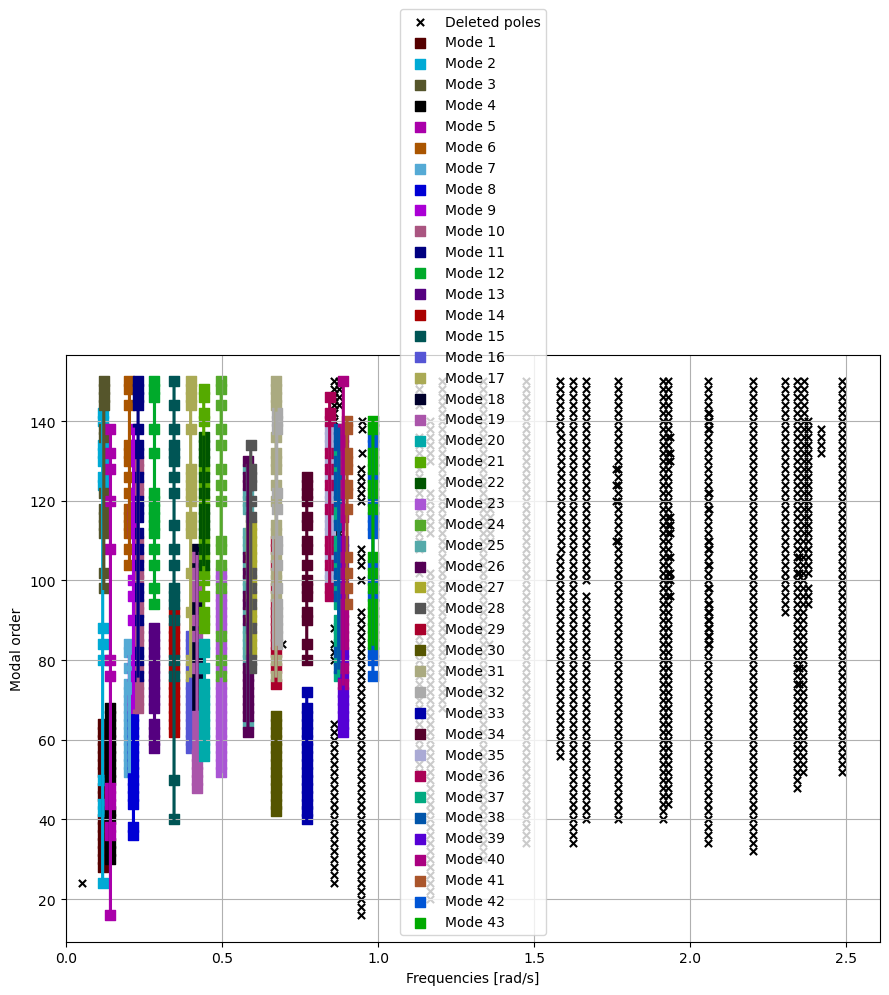

In [18]:
import plot_koma
plt.figure(figsize=(15, 8), dpi=80)
fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, lambd= lambd_stab, all_orders= orders_stab)
plt.grid()

In [19]:
from python_appendix import OMA_functions as OMA

# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)

grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only

print(len(grouped_phis))

phi_extracted = np.zeros((len(grouped_phis), 48))
print(phi_extracted.shape)

for i in range(len(grouped_phis)):
    for j in range(np.shape(grouped_phis[i])[0]):
       phi_extracted[i,j] = (np.real(np.mean(grouped_phis[i][j])))

phi_extracted = phi_extracted.transpose()
print(phi_extracted.shape)

43
(43, 48)
(48, 43)


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/python_appendix/OMA_functions.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(4, 1, figsize=(7,10))


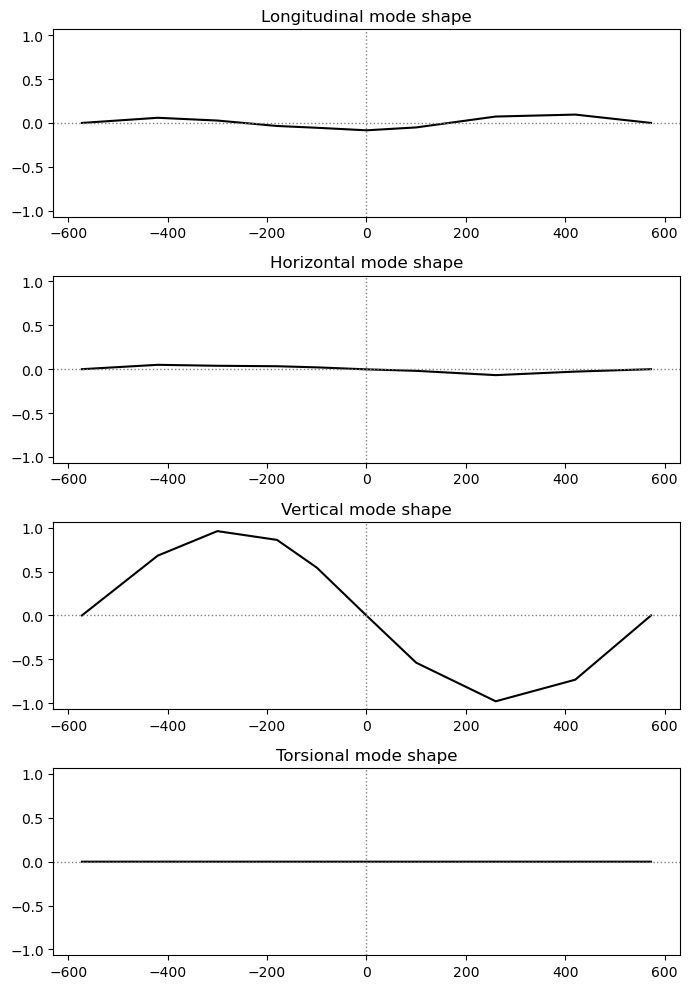

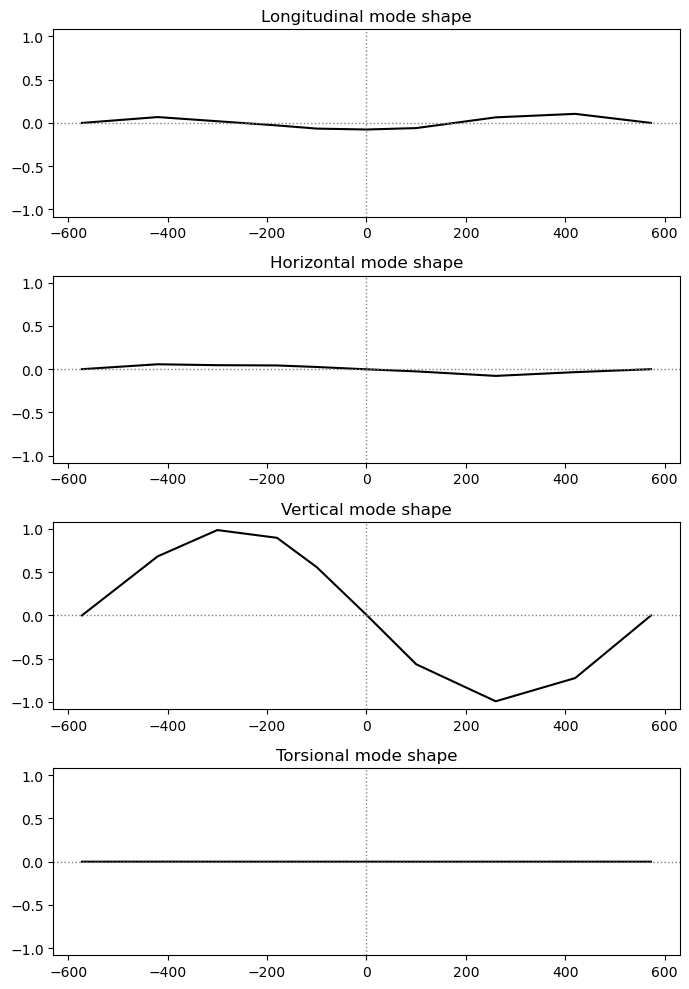

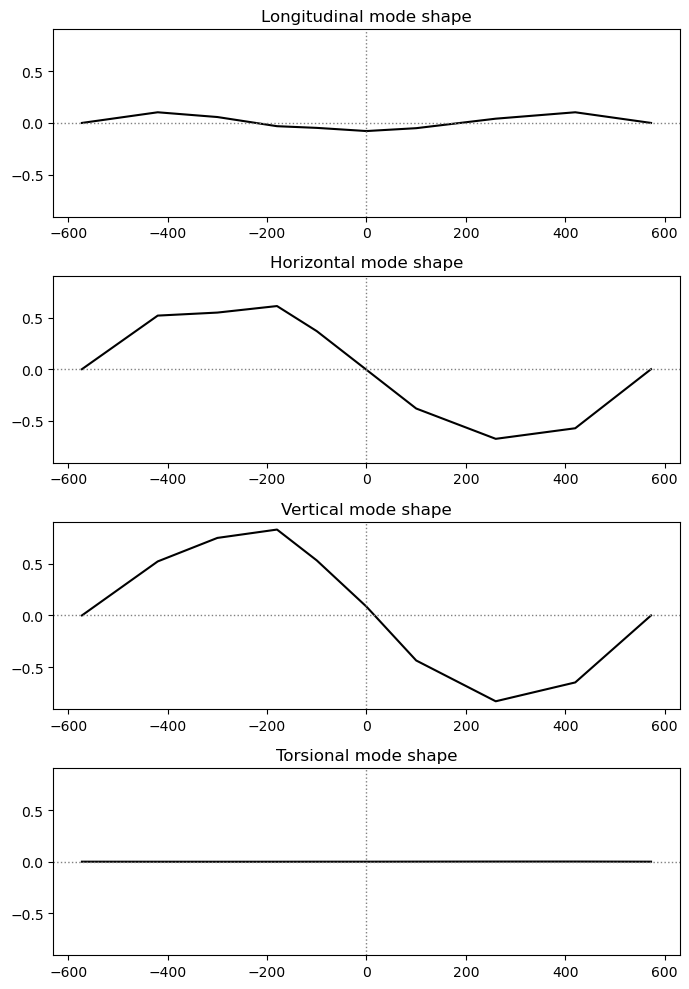

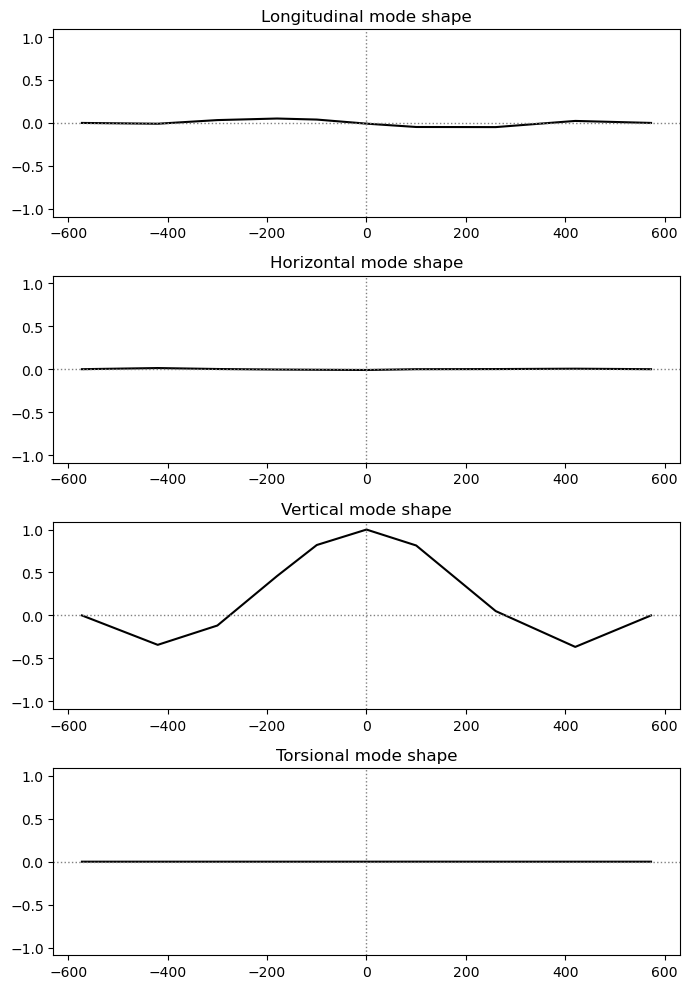

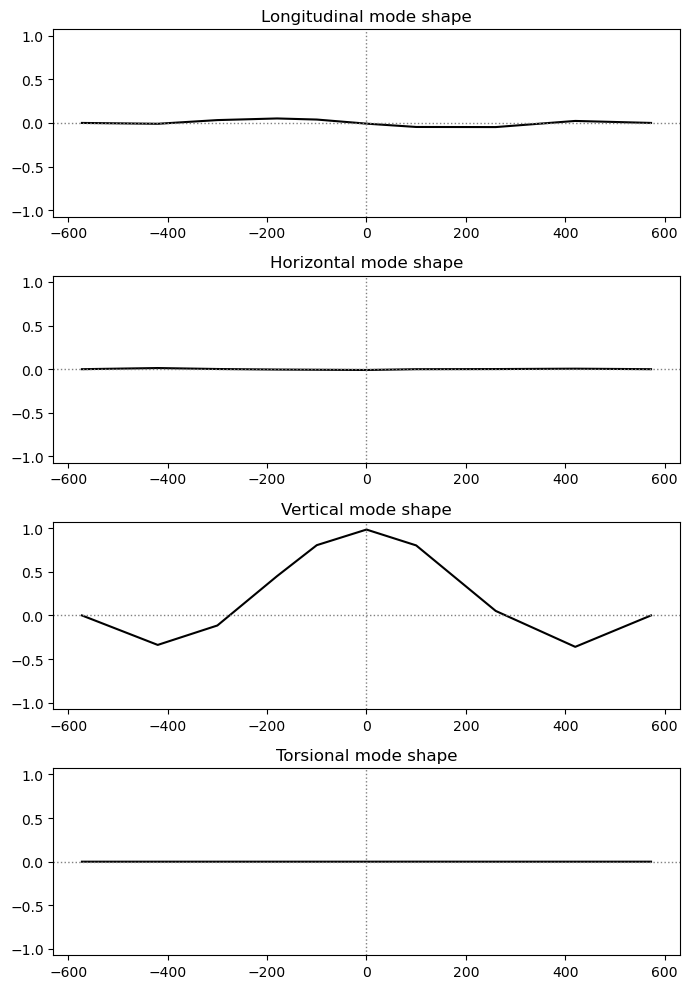

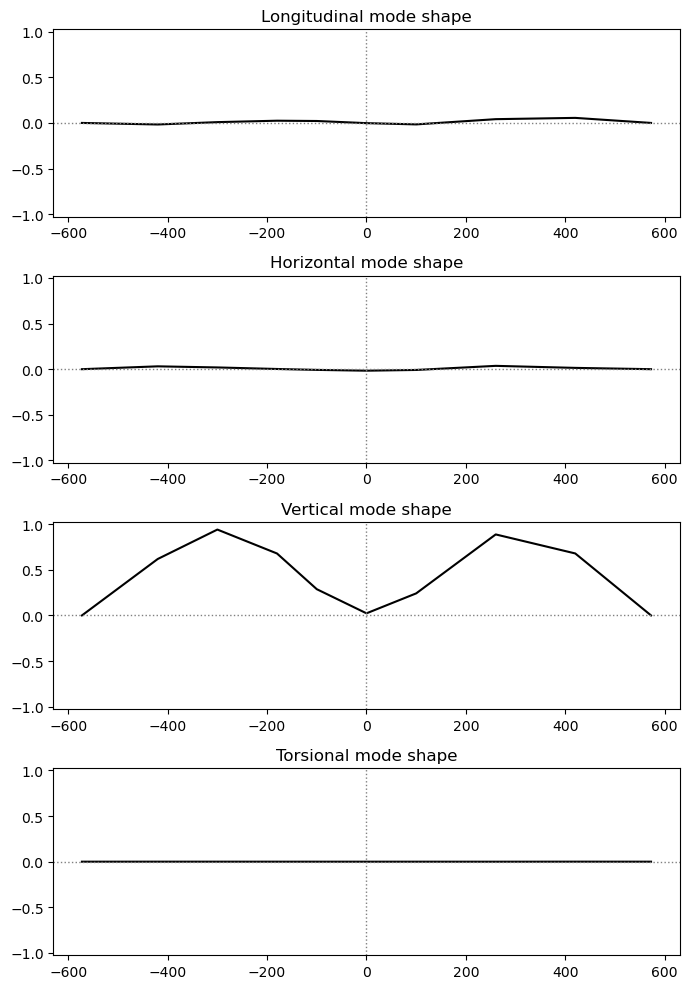

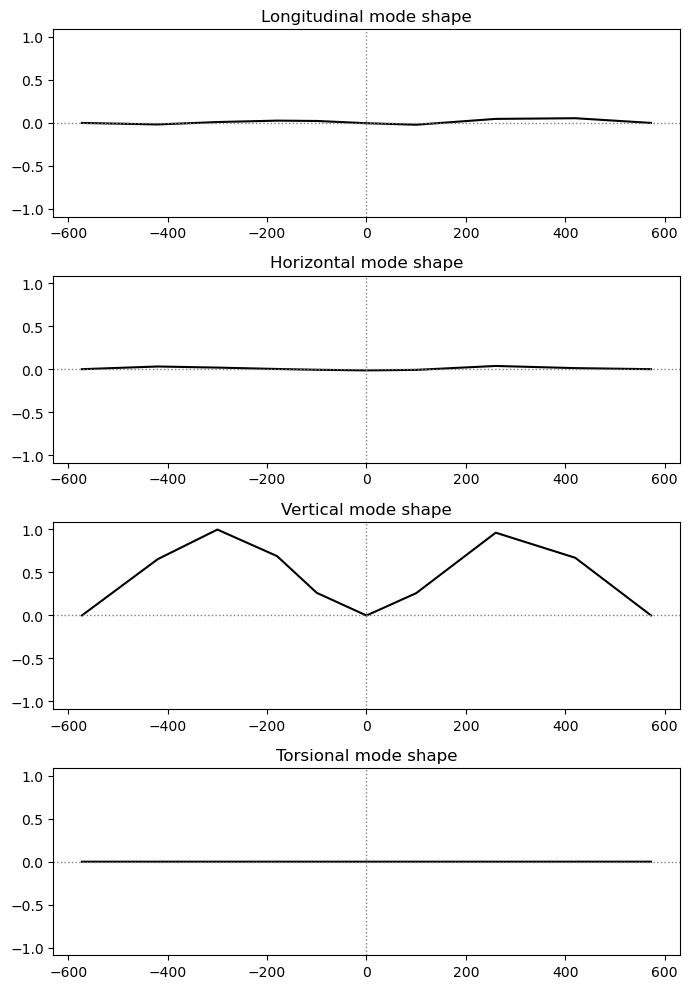

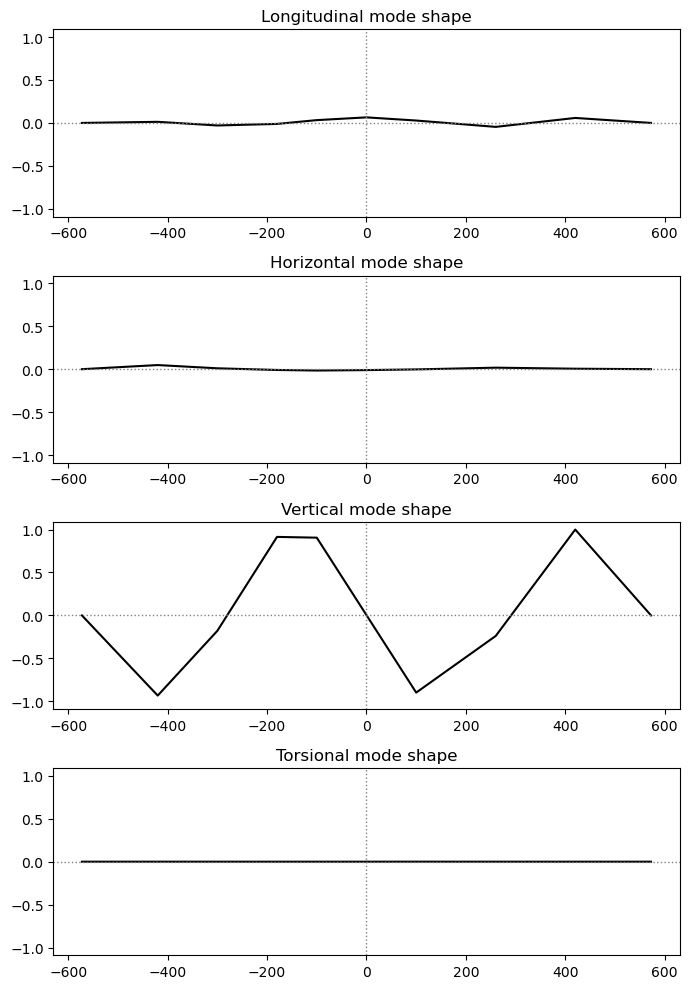

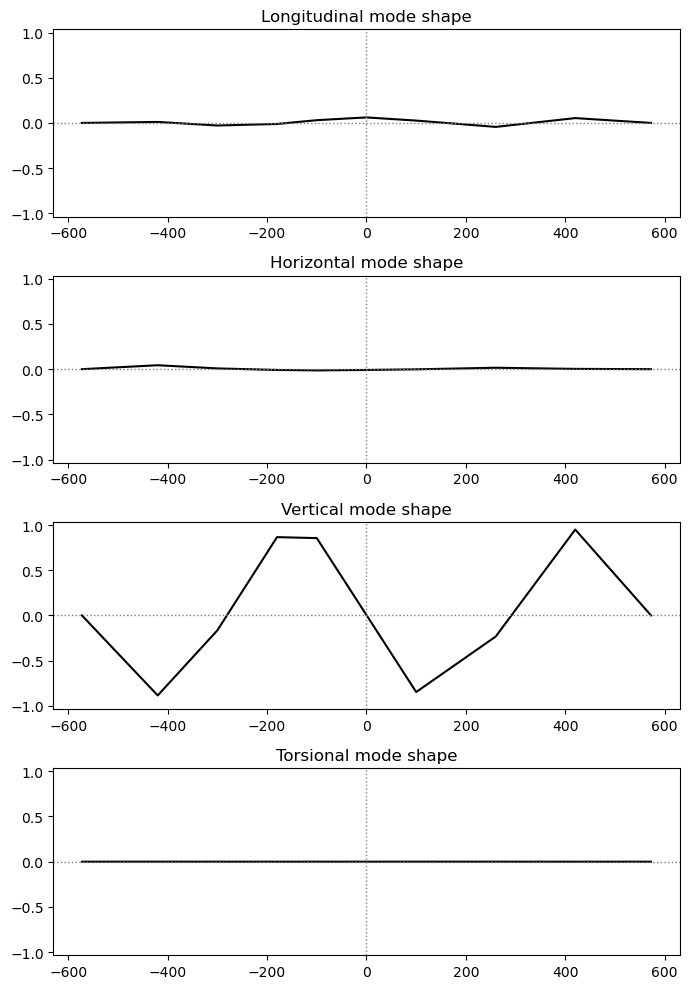

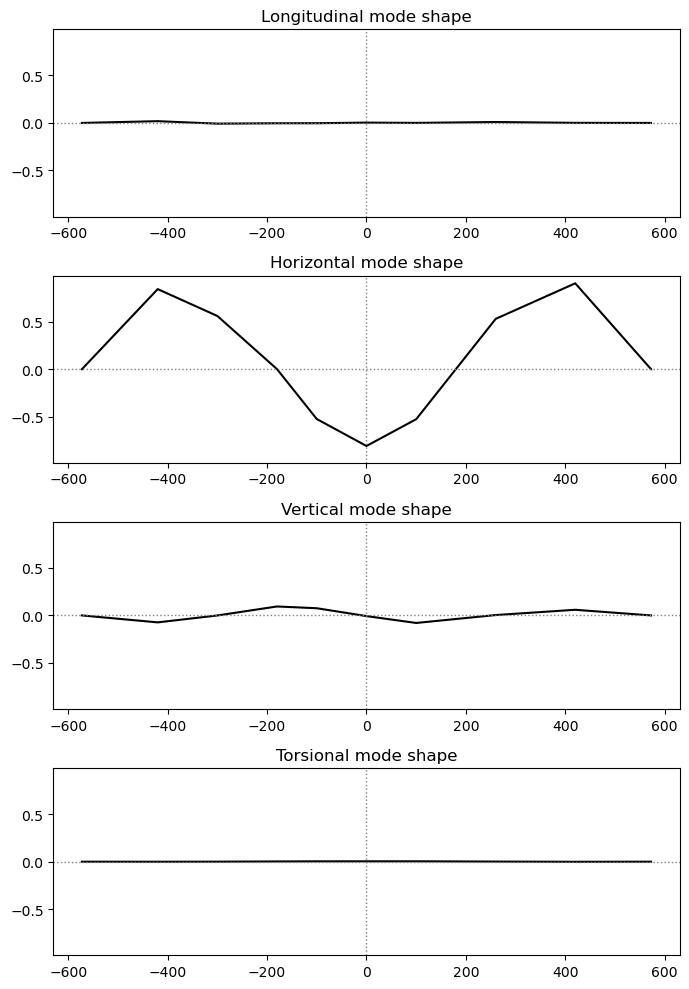

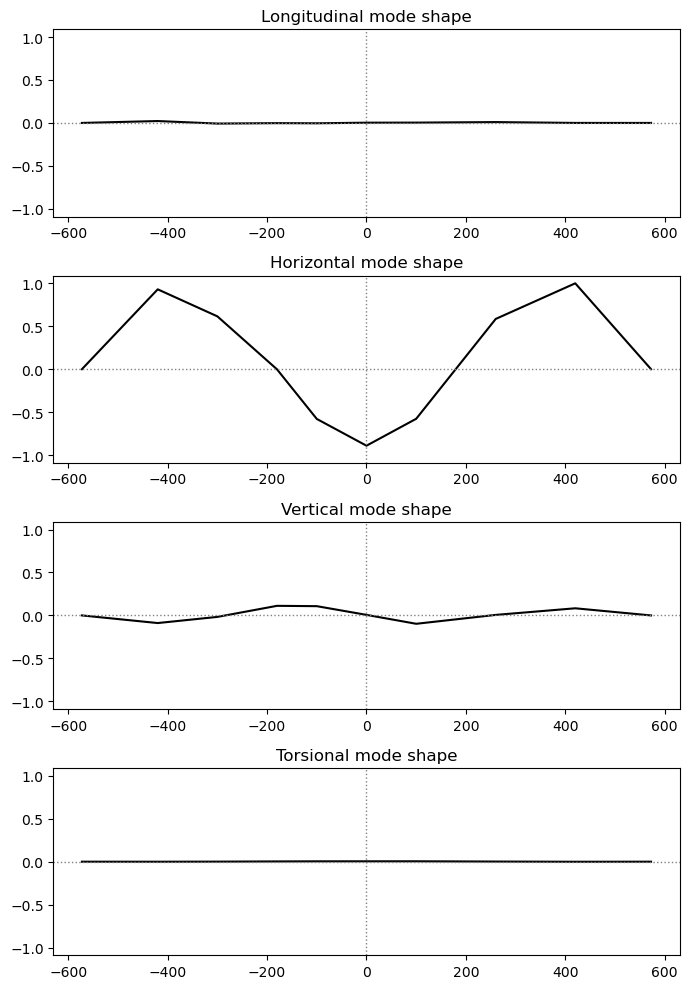

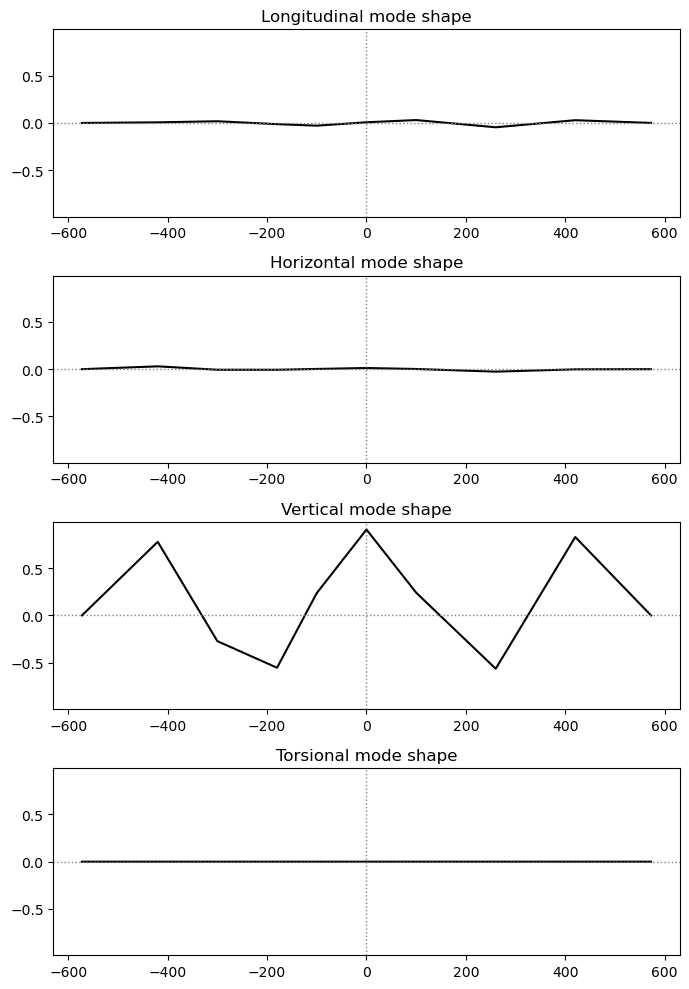

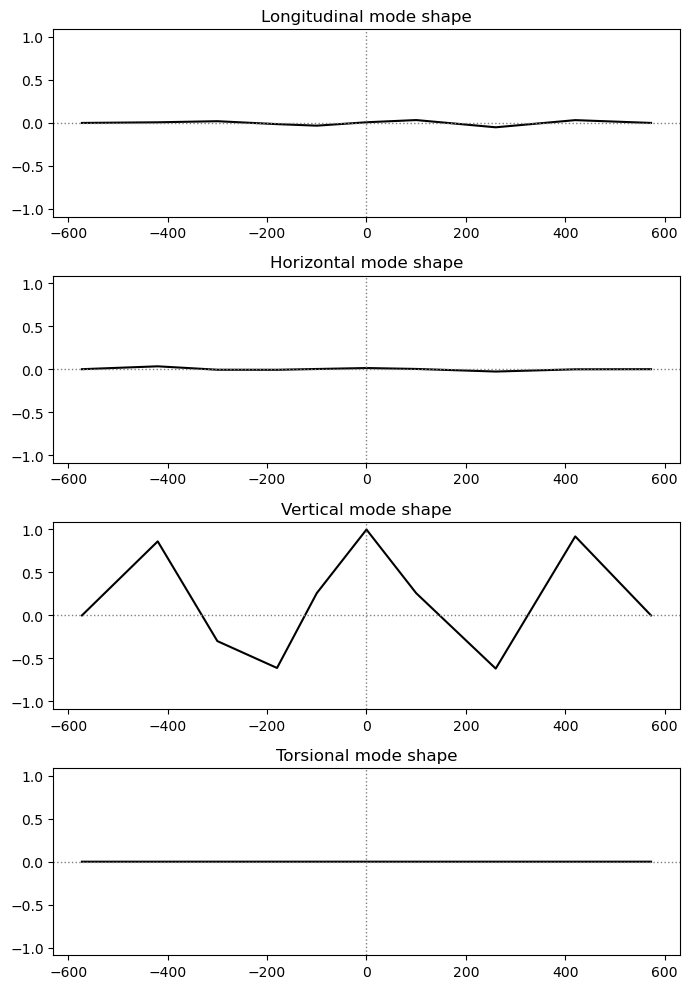

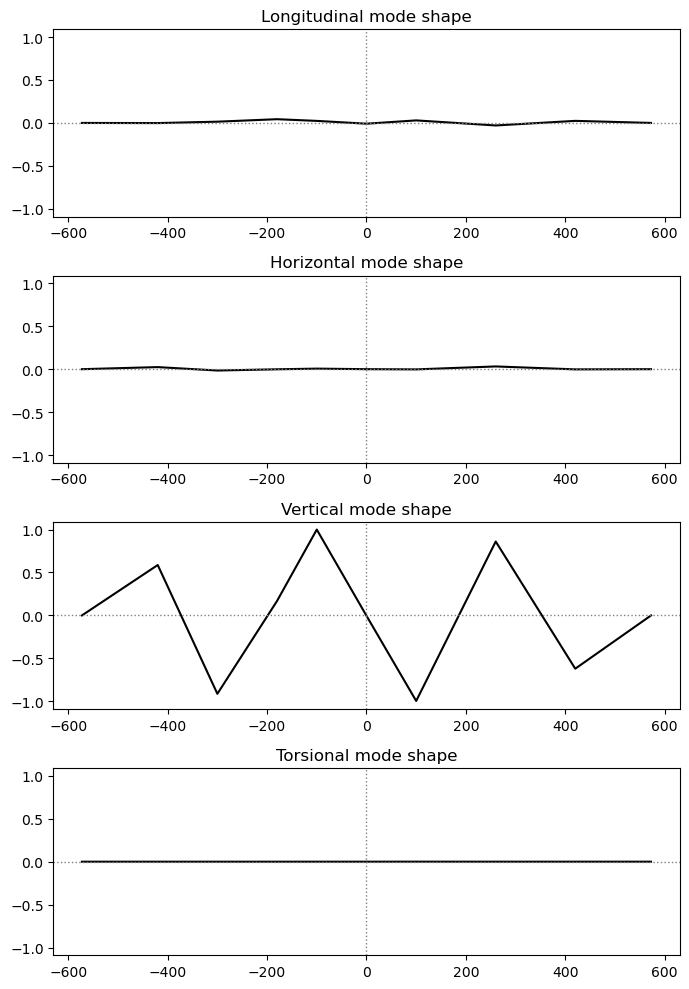

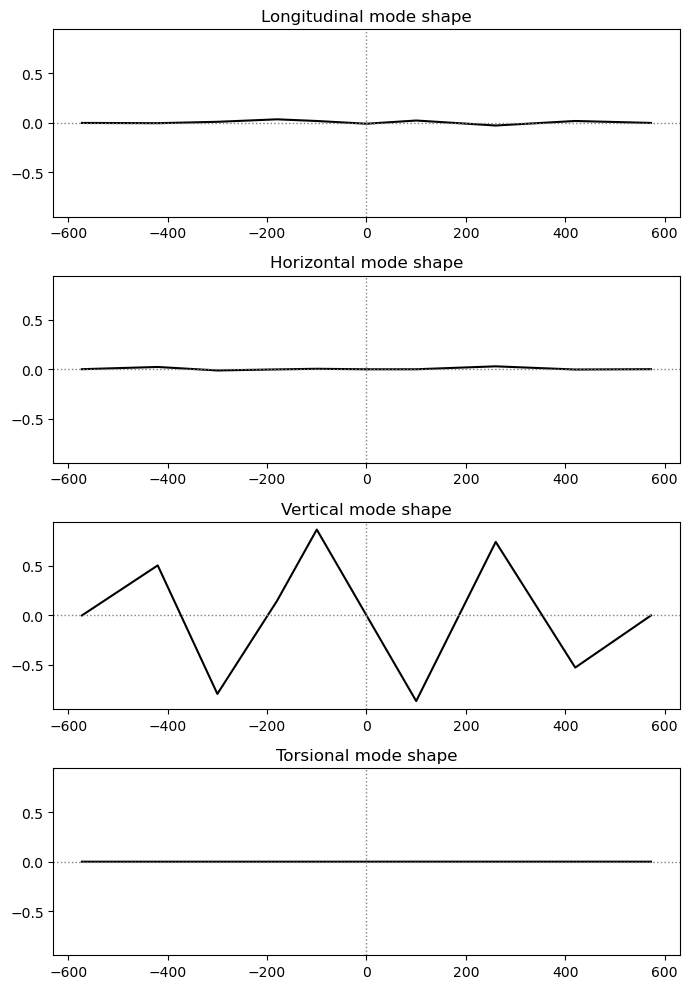

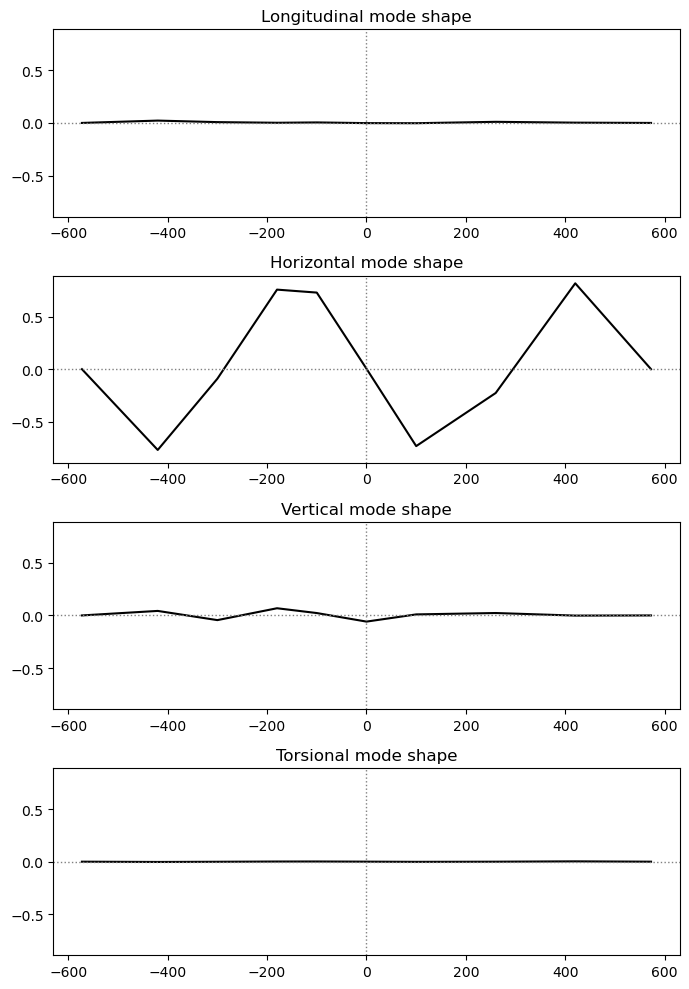

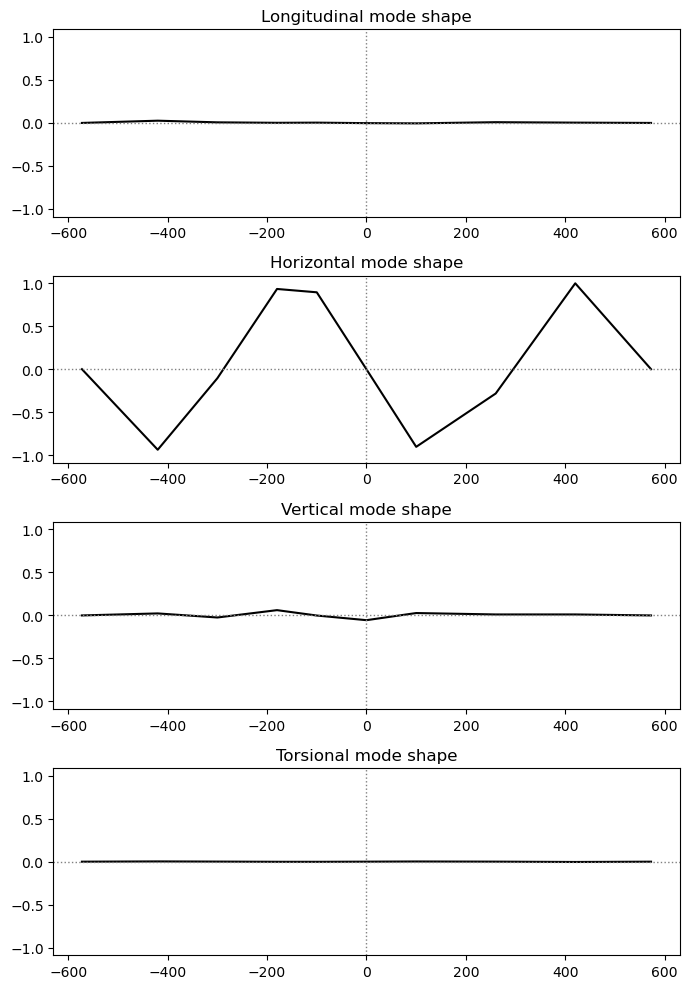

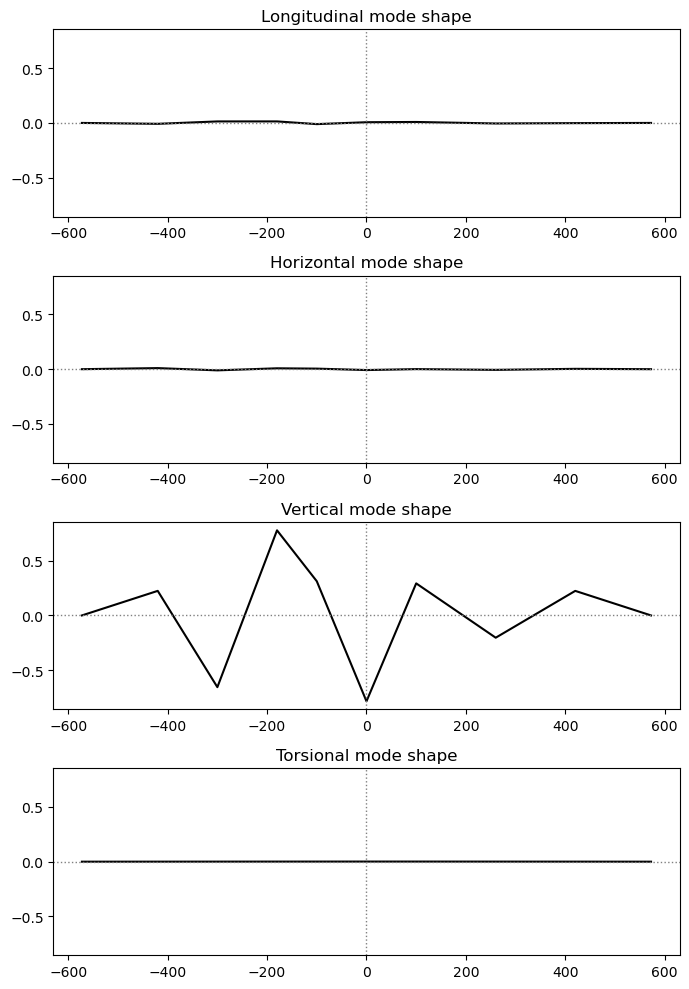

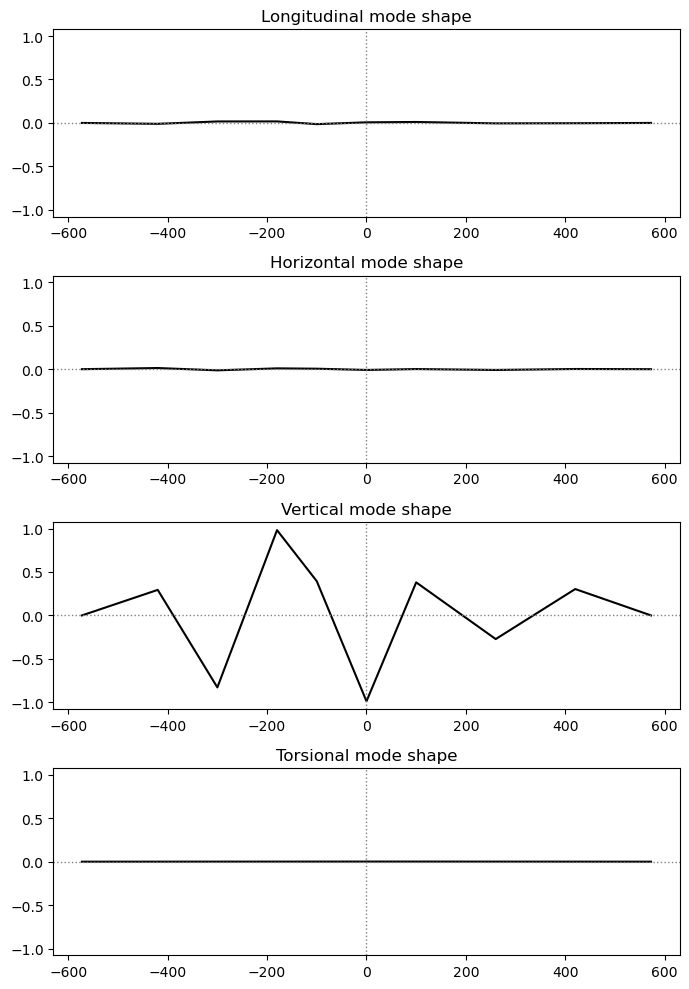

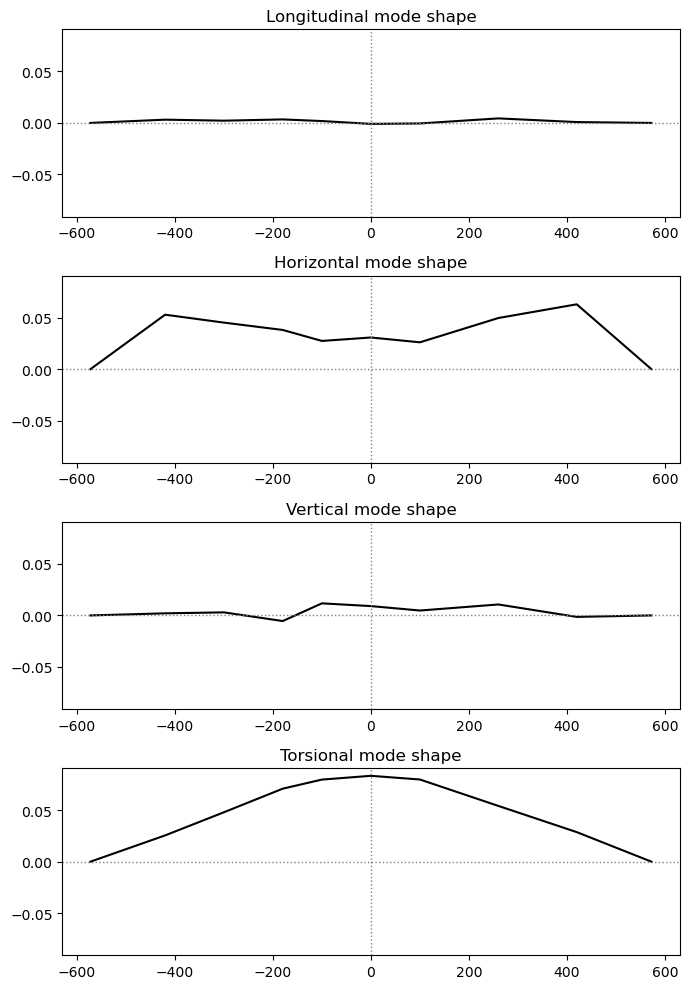

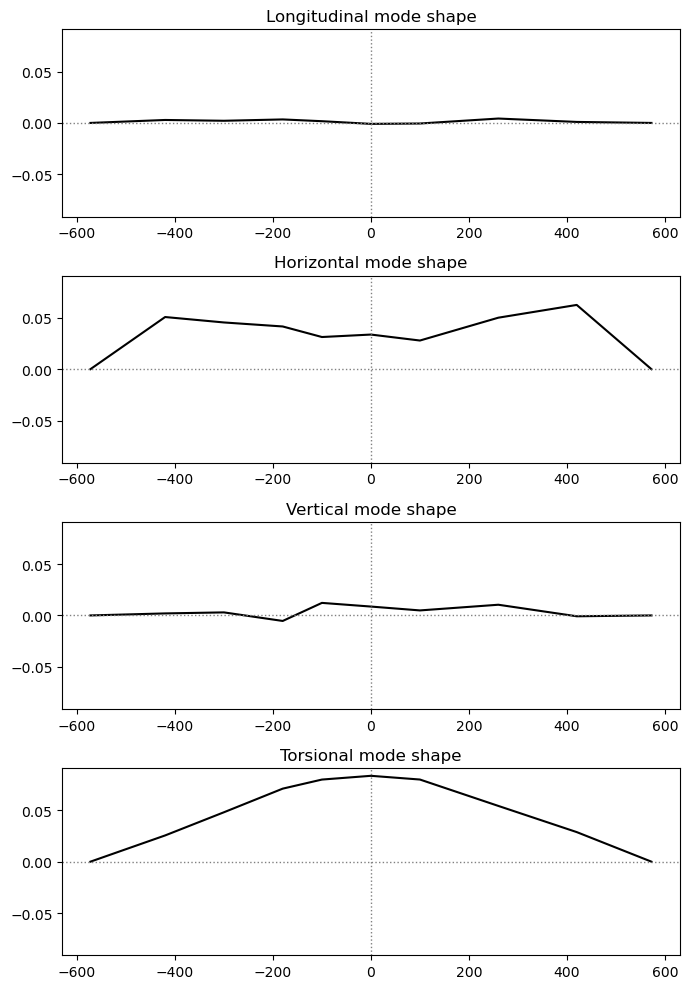

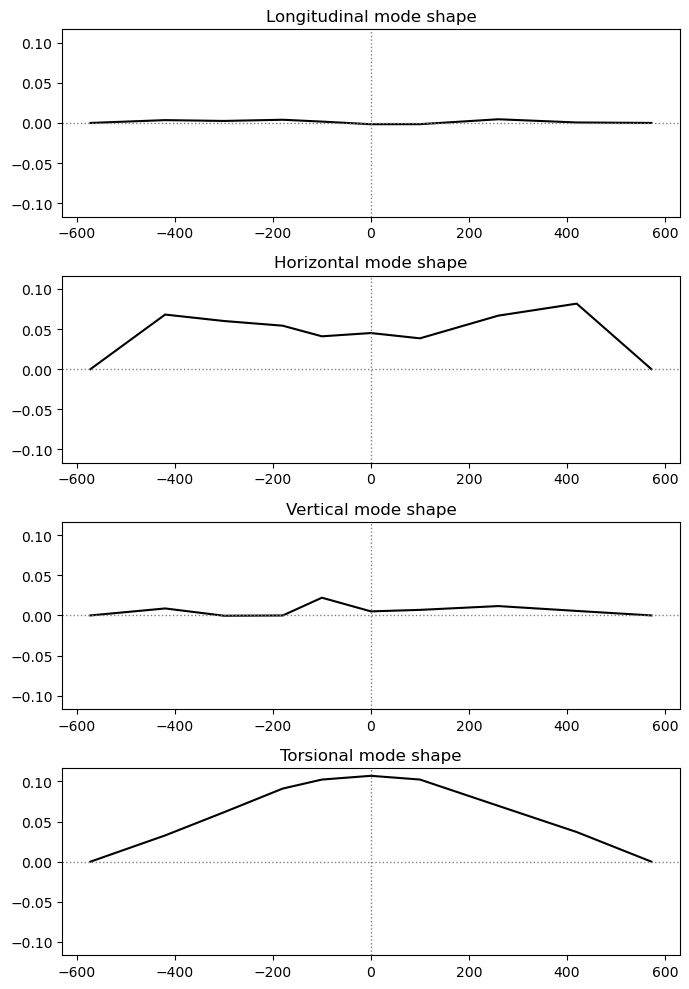

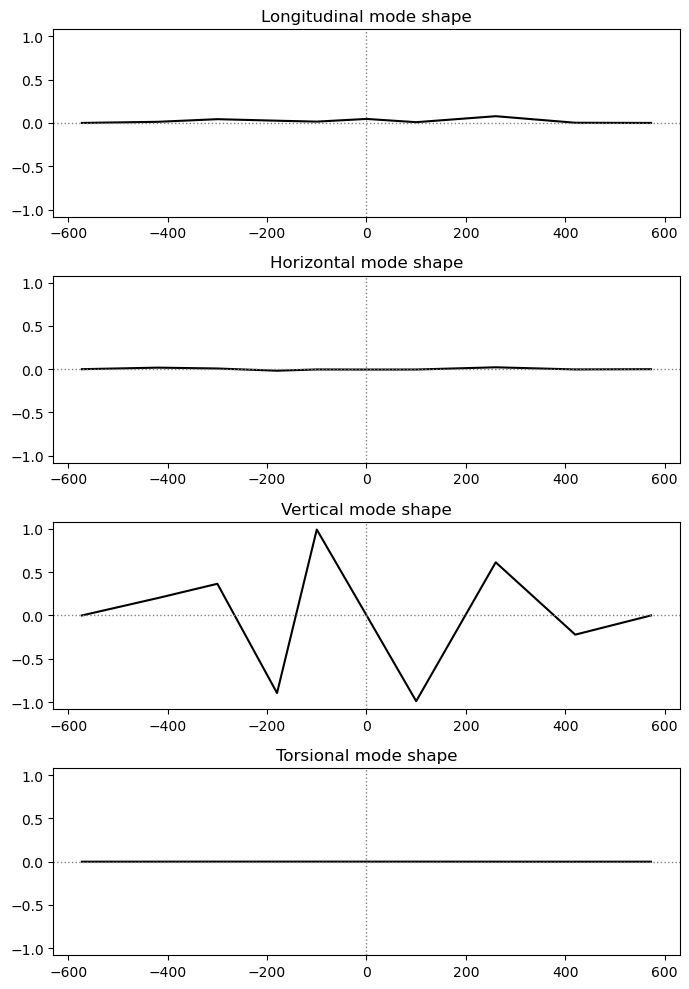

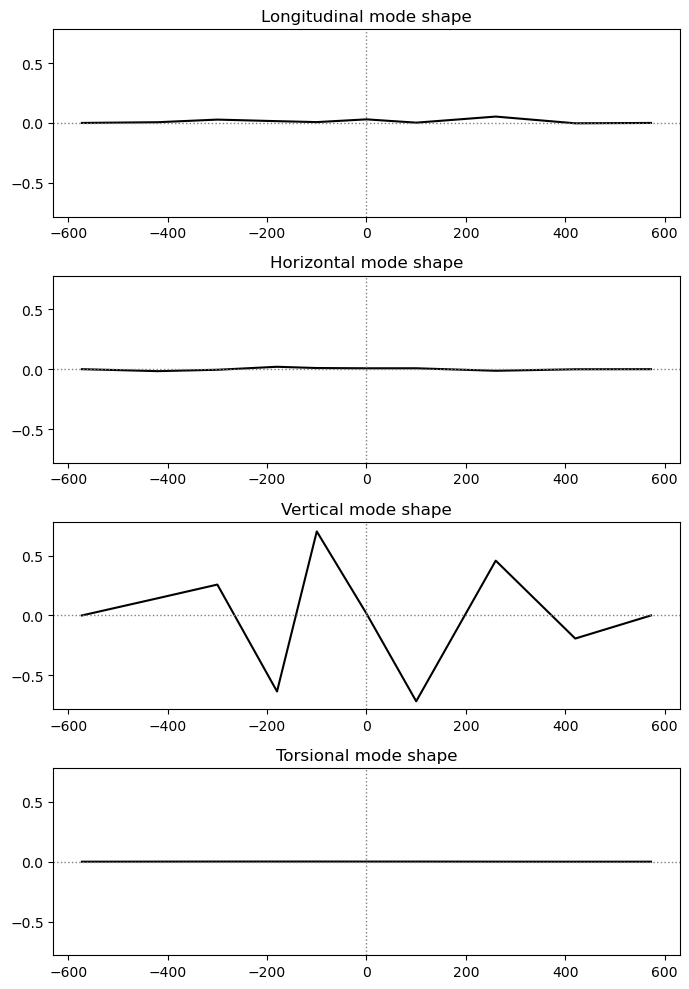

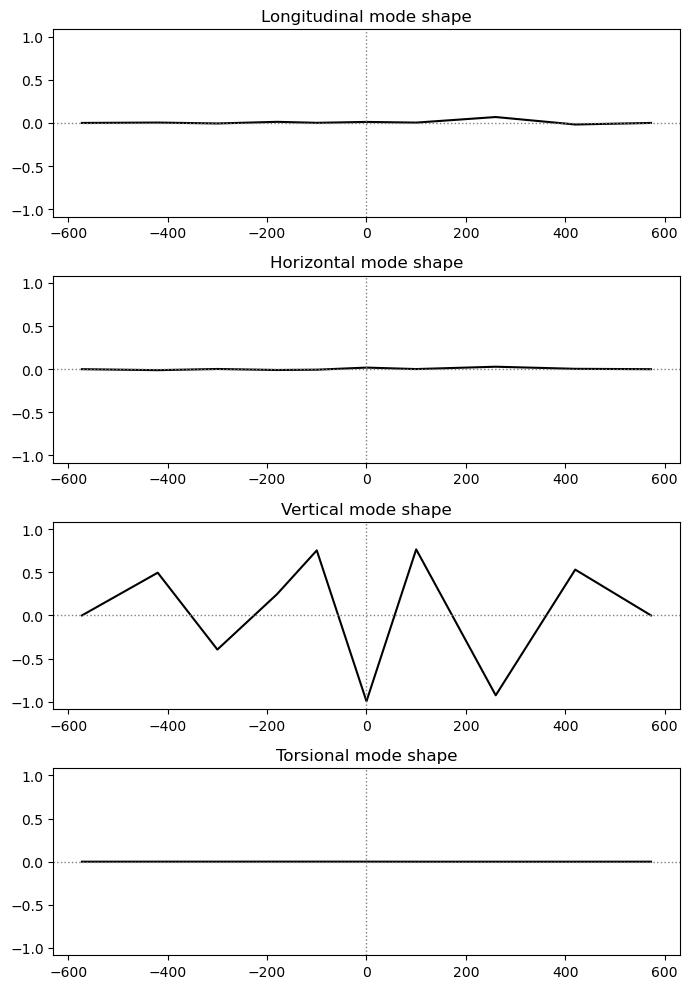

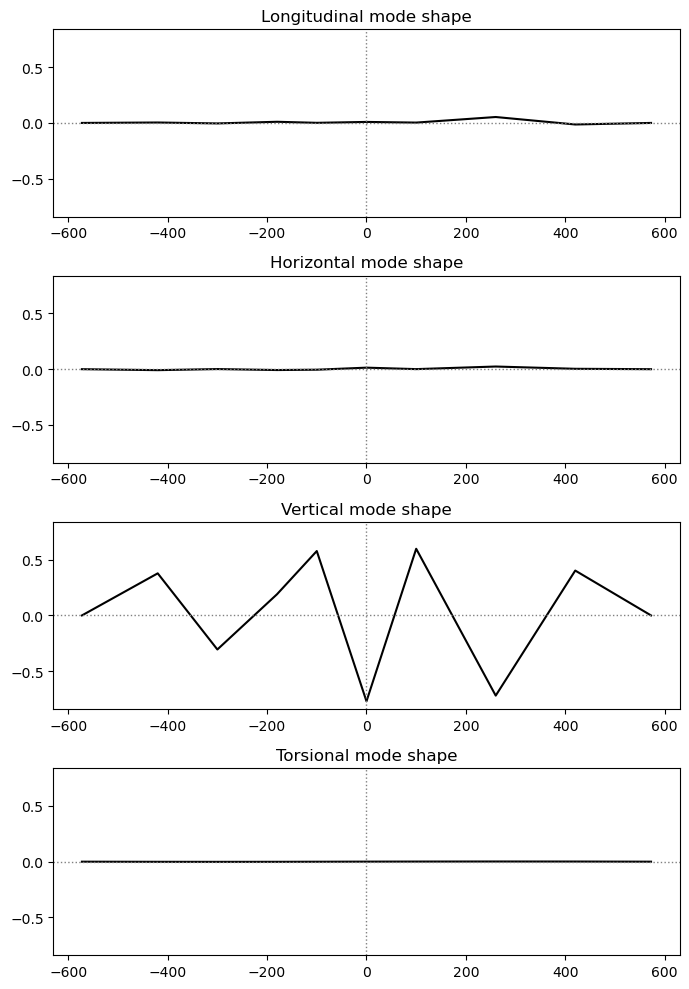

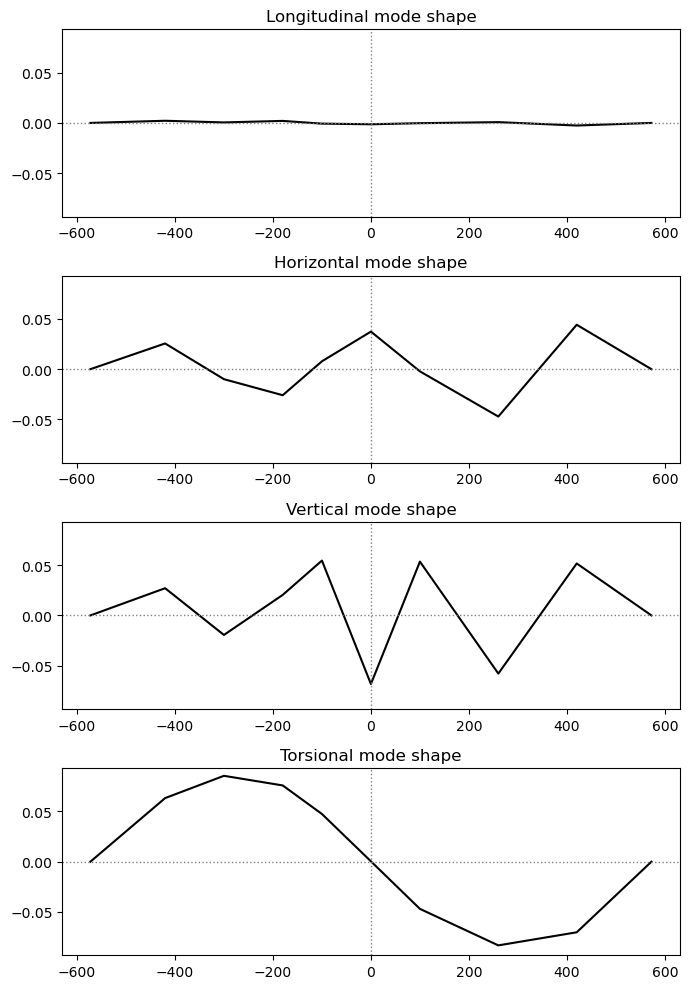

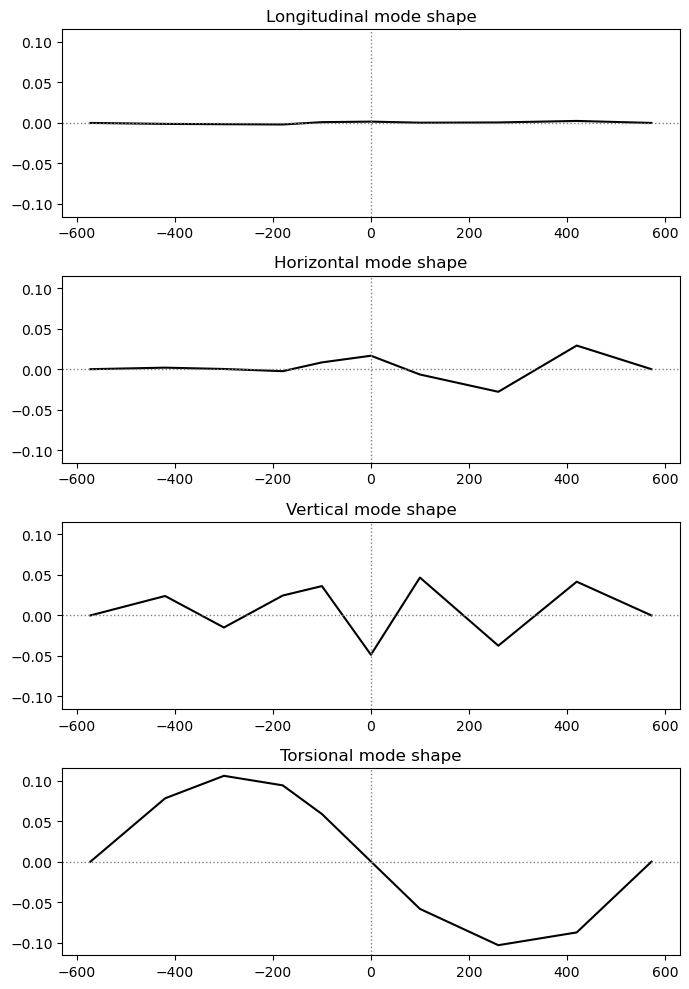

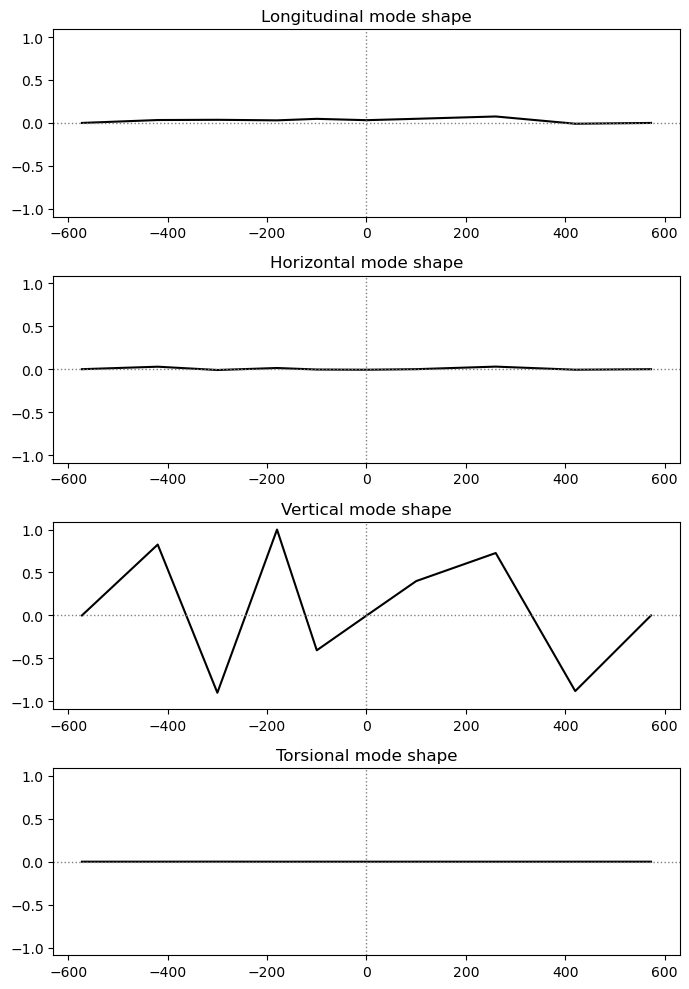

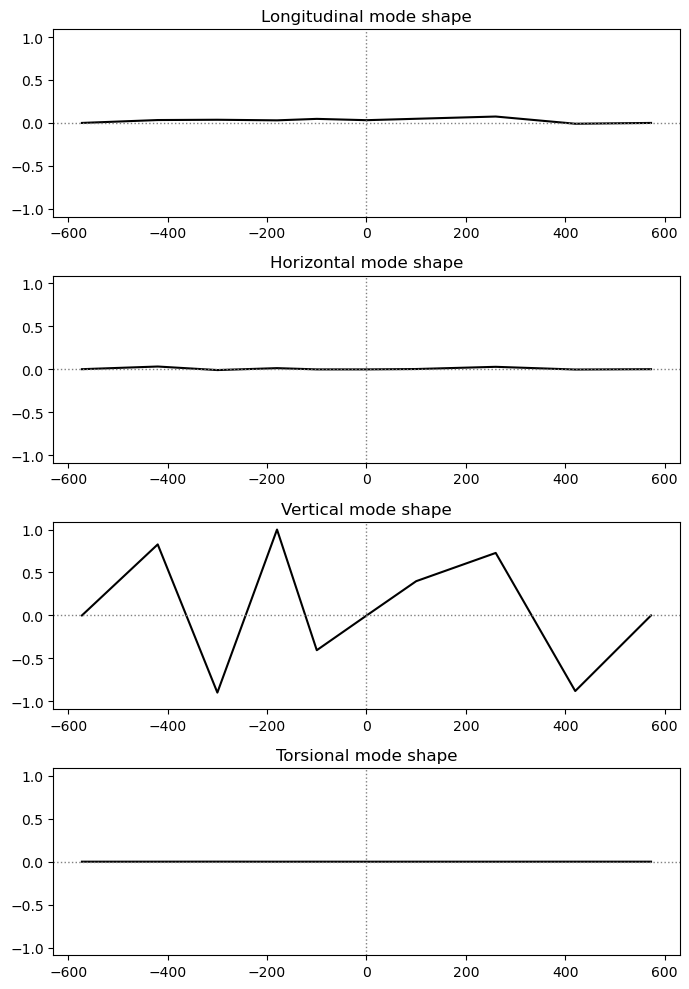

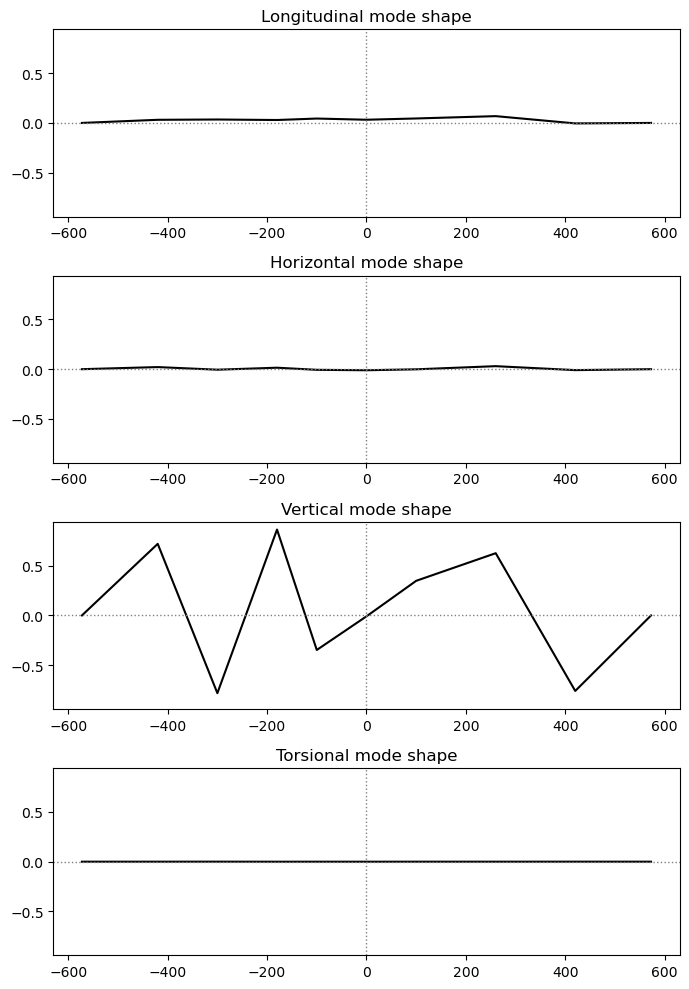

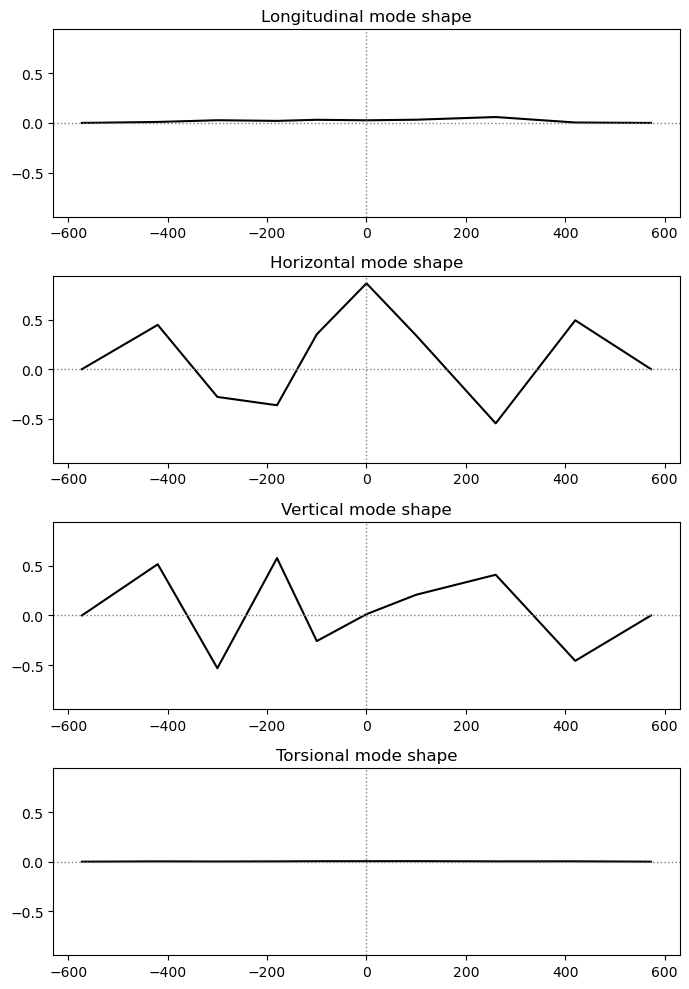

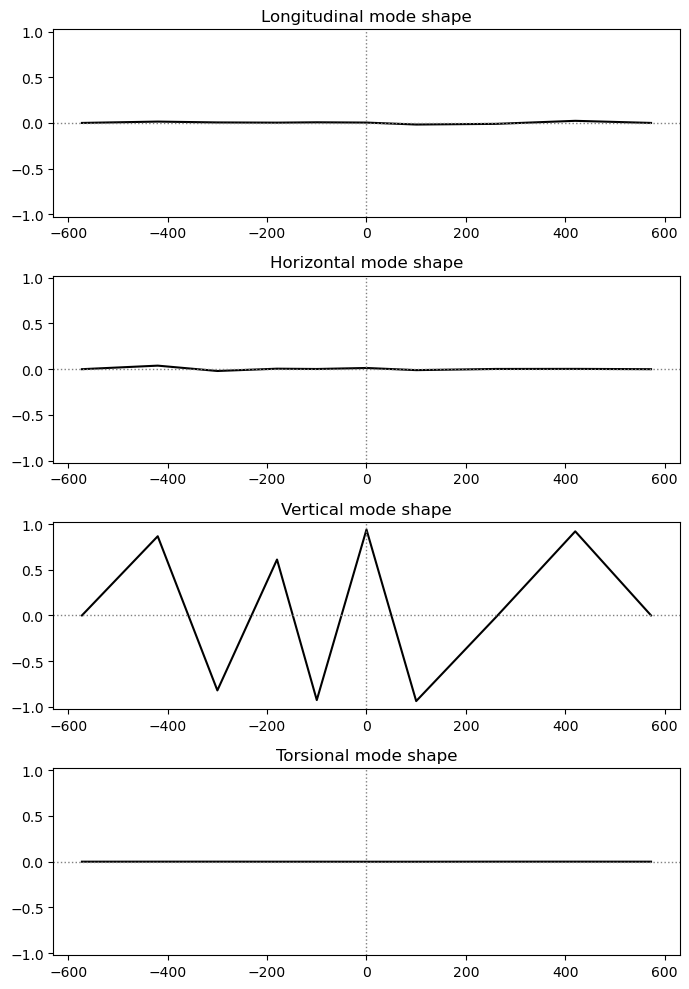

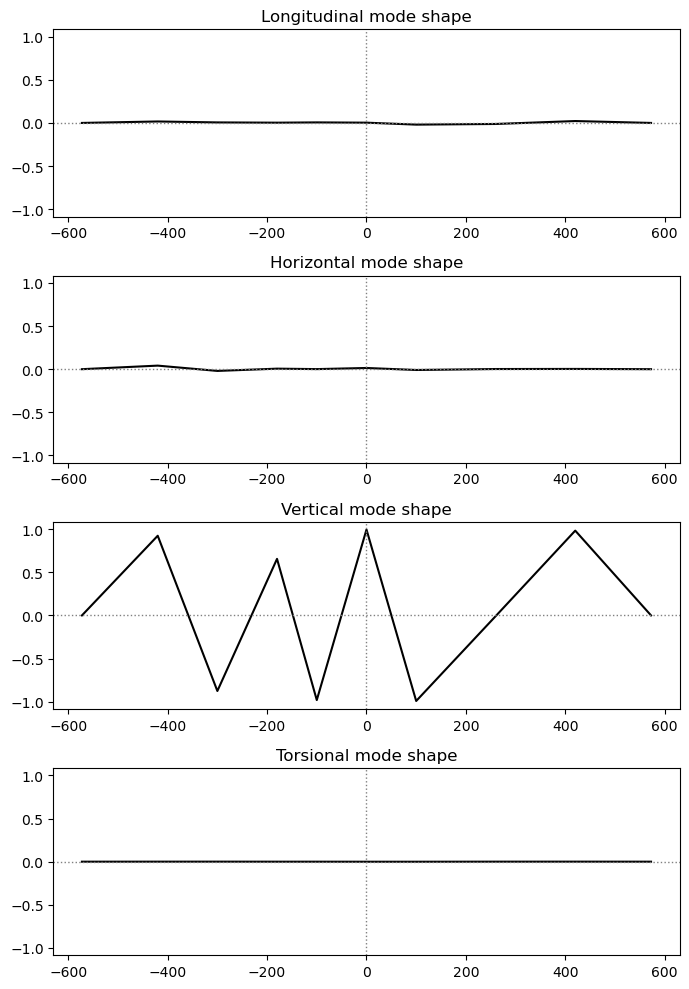

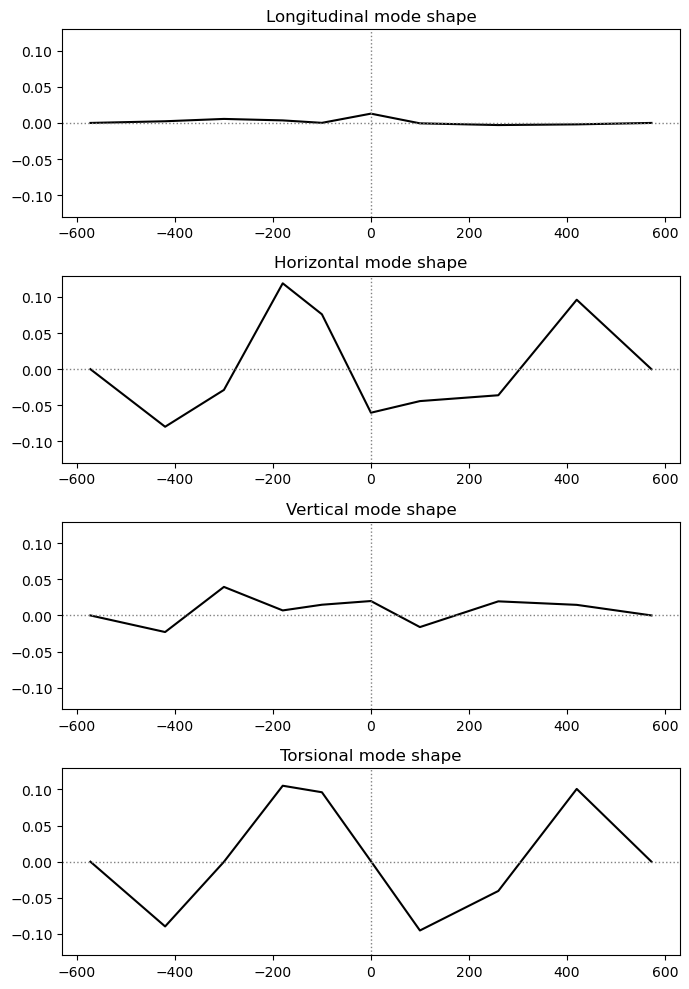

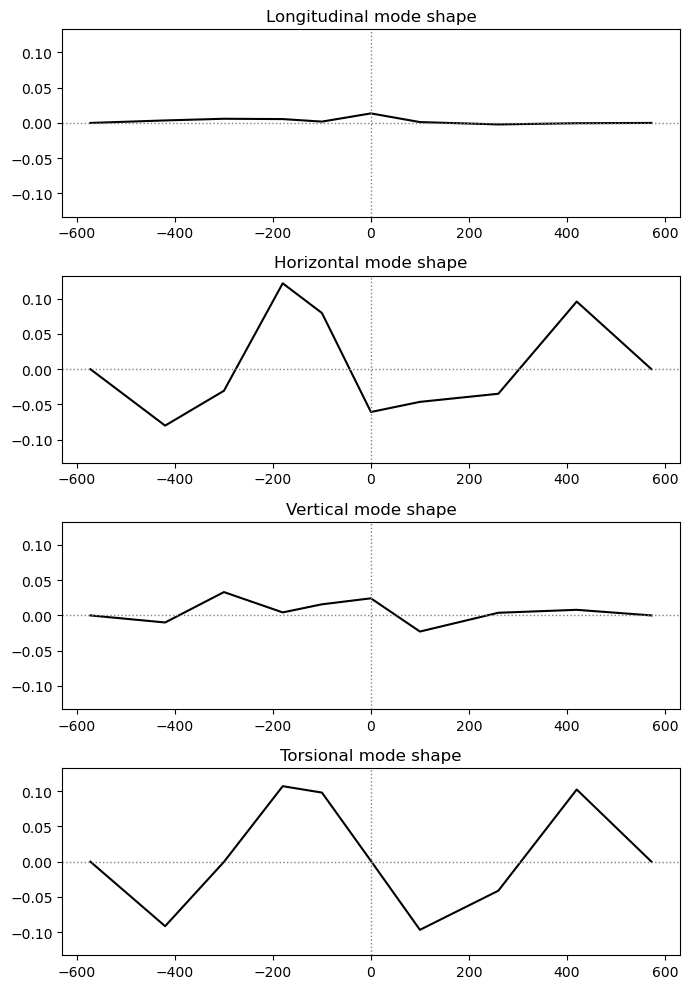

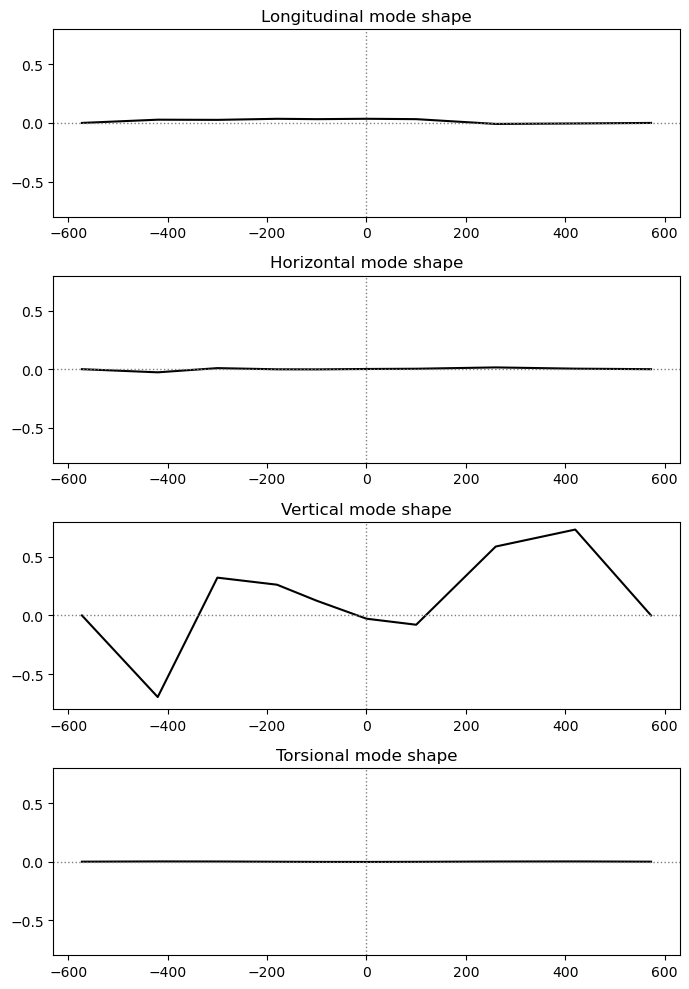

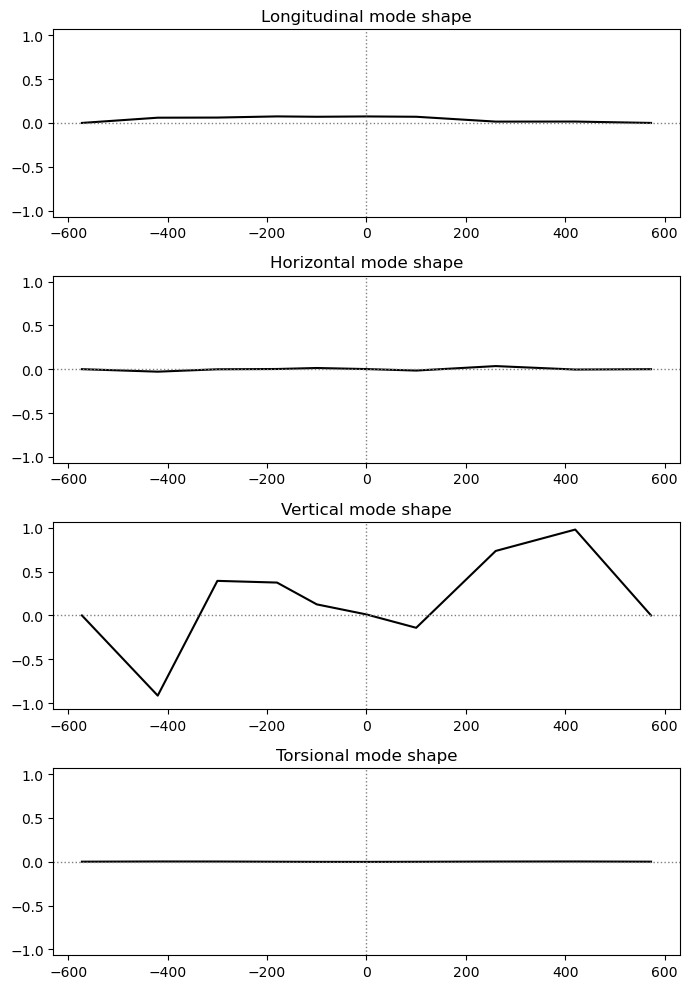

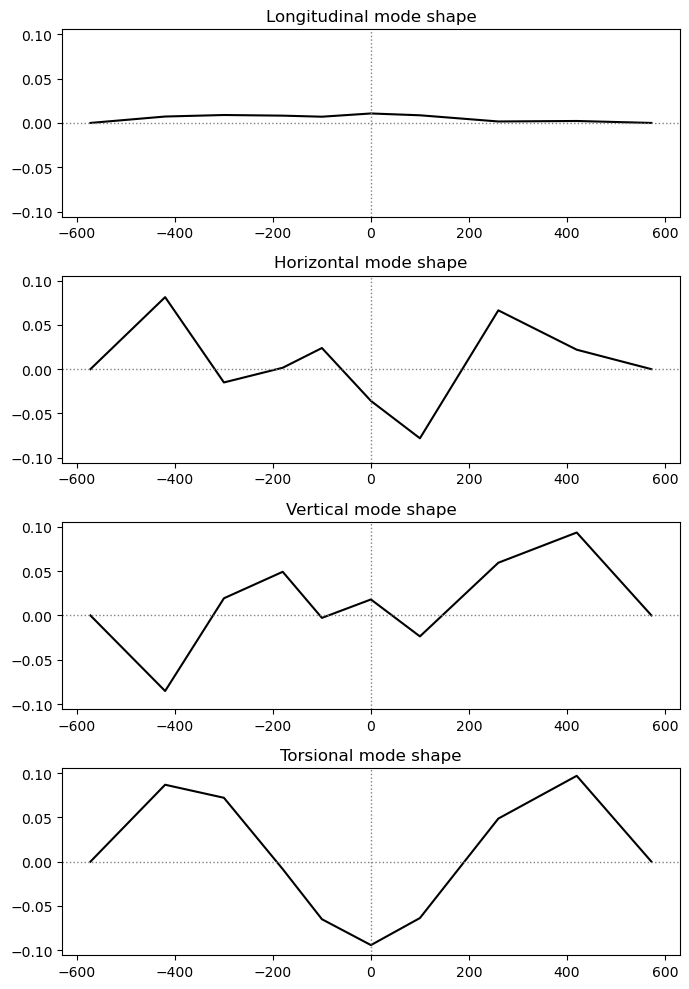

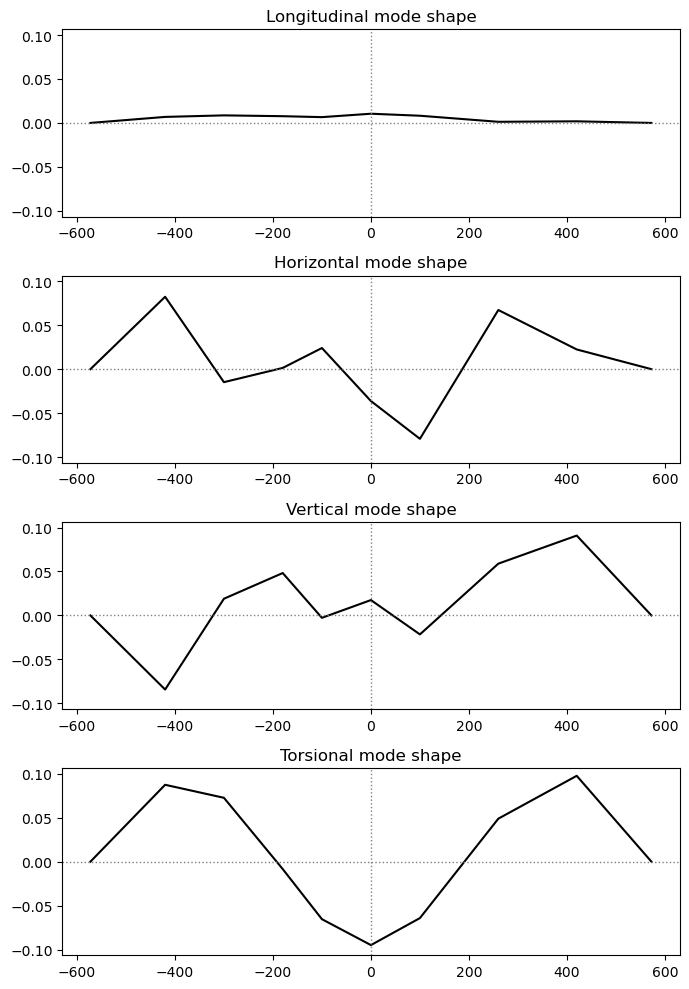

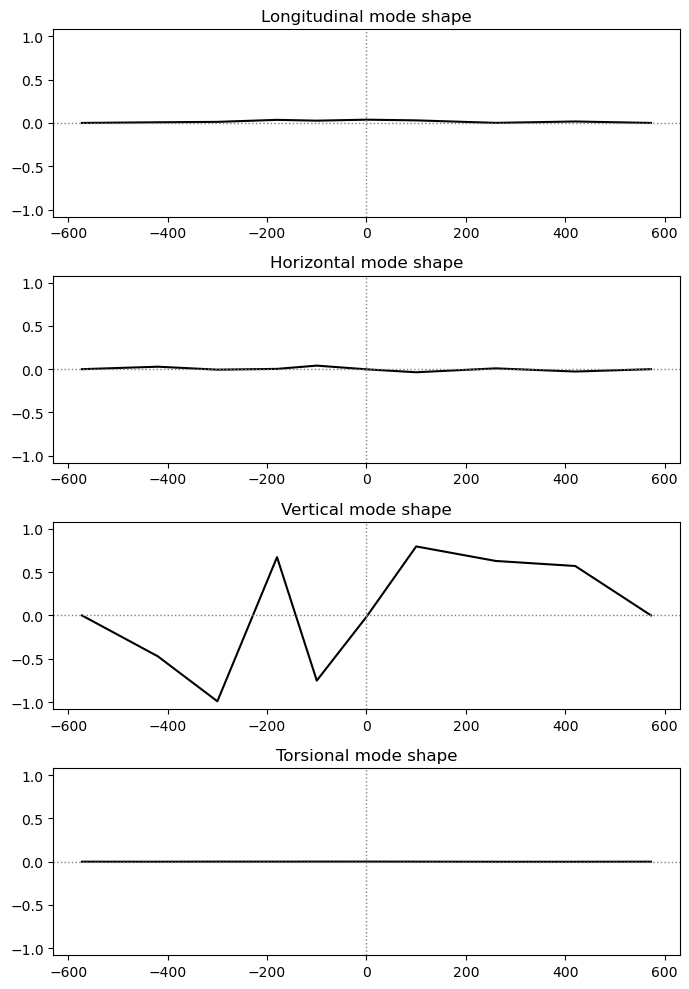

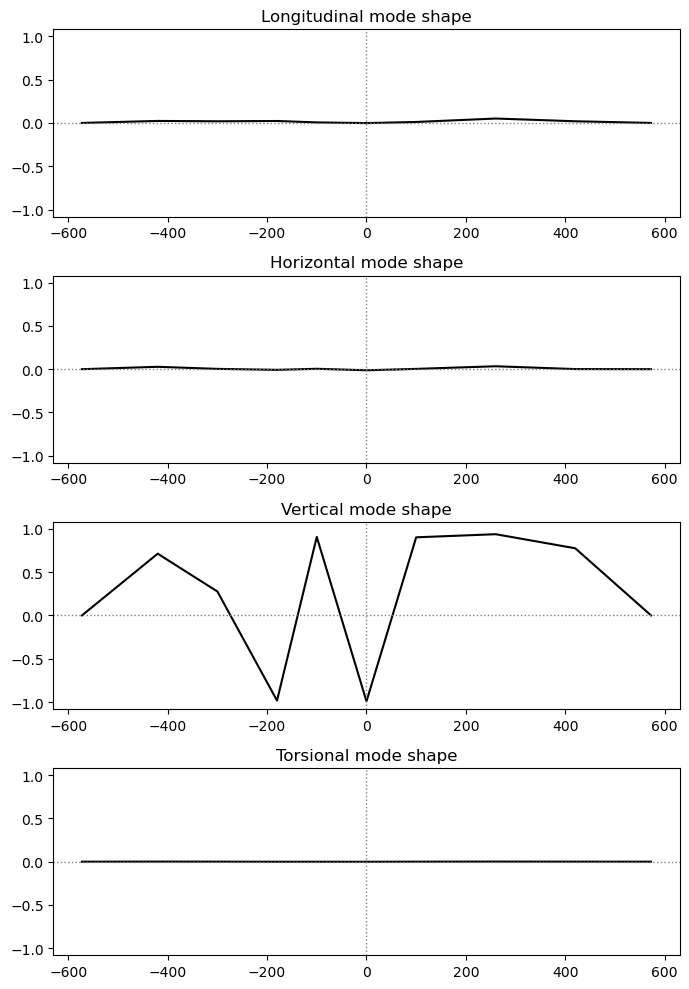

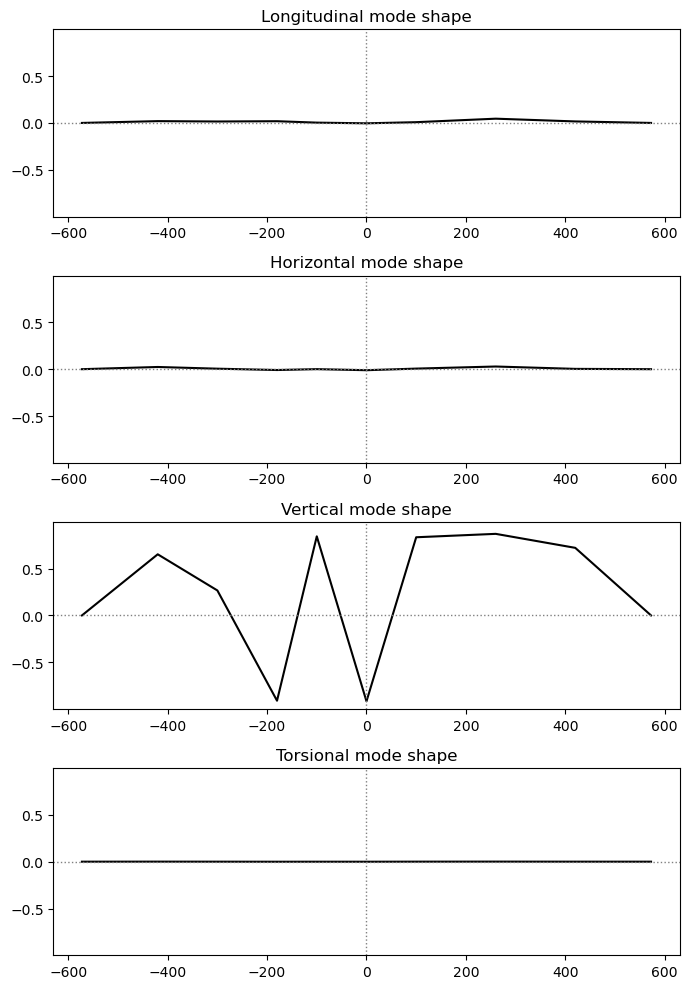

In [20]:
for i in range(phi_extracted.shape[1]):
    fig_shape = OMA.plotModeShape(phi_extracted, i)
    plt.savefig("plots/emil/modeshape_mode_" + str(i+1) + ".jpg")